In [1]:
import tensorflow.compat.v1 as tf
tf.compat.v1.disable_eager_execution()
import pandas as pd
import numpy as np
np.set_printoptions(threshold=np.inf)
import matplotlib
import matplotlib.pyplot as plt
import time
import os
import math
from math import exp, pi,sin,cos

np.random.seed(1)
tf.set_random_seed(1)
###########设置定义域范围

a =-pi/2
b = pi/2

In [2]:
class PhysicsInformedNN:
    # Initialize the class
    def __init__(self, layers_U, layers_V1,layers_V2,layers_V3, layers_V4,layers_V5,x_range, f, num_train_tps):

        # Initialize NNs
        self.layers_U = layers_U
        self.weights_U, self.biases_U, self.adaps_U = self.initialize_NN(layers_U)
        self.layers_V1 = layers_V1
        self.weights_V1, self.biases_V1, self.adaps_V1 = self.initialize_NN(layers_V1)
        self.layers_V2 = layers_V2
        self.weights_V2, self.biases_V2, self.adaps_V2 = self.initialize_NN(layers_V2)
        self.layers_V3 = layers_V3
        self.weights_V3, self.biases_V3, self.adaps_V3 = self.initialize_NN(layers_V3)
        self.layers_V4 = layers_V4
        self.weights_V4, self.biases_V4, self.adaps_V4 = self.initialize_NN(layers_V4)
        self.layers_V5 = layers_V5
        self.weights_V5, self.biases_V5, self.adaps_V5 = self.initialize_NN(layers_V5)
        # Parameters
        self.x_range =x_range
        self.lb = np.array([ x_range[0]])
        self.ub = np.array([ x_range[1]])
        # Output file
        self.f = f
        # Coordinates of datapoints             #####################数据点坐标
        self.xx_tf = tf.placeholder(tf.float32, shape=[None, 1])
        # Test Points                           ######################测试点
        self.x_test_tf = tf.placeholder(tf.float32, shape=[None, 1])

        # Generate Training and Testing Points  ########################生成训练和测试点
        self.generateTrain(num_train_tps)

        # Physics
        self.f, self.e1,self.e2,self.e3,self.e4,self.e5,  self.Uf, self.V1f,self.V2f,self.V3f,self.V4f,self.V5f,self.U_xf,self.V1_xf,self.V2_xf,self.V3_xf,self.V4_xf,self.V5_xf,self.V1e,self.V2e,self.V3e,self.V4e,self.V5e= self.pinn(self.xf)
        _,_,_,_,_,_,self.Ui, self.V1i,self.V2i,self.V3i,self.V4i,self.V5i,_,_,_,_,_,_,_,_,_,_,_= self.pinn(self.xi)
        _,_,_,_,_,_,_,_,_,_,_,_,_,_,_,_,_,_,self.V1e,self.V2e,self.V3e,self.V4e,self.V5e= self.pinn(self.xe)
        self.f_test,  self.e1_test, self.e2_test,self.e3_test,self.e4_test,self.e5_test,self.U_test, self.V1_test,self.V2_test,self.V3_test,self.V4_test,self.V5_test,self.U_x_test,self.V1_x_test,self.V2_x_test,self.V3_x_test,self.V4_x_test,self.V5_x_test,_,_,_,_,_= self.pinn(self.x_test_tf)
        # 均方误差
        self.loss_f = tf.reduce_mean((self.U_xf-(self.xf**2-1.0)*self.V1e+0.5*self.xf**2*(self.xf**2-1.0)*self.V2e-self.xf**4*(self.xf**2-1.0)*self.V3e*1/24+self.xf**6*(self.xf**2-1.0)*self.V4e*1/720-self.xf**8*(self.xf**2-1.0)*self.V5e*1/40320-tf.cos(self.xf))** 2)
        self.loss_e1 = tf.reduce_mean((self.V1_xf -self.Uf)** 2)
        self.loss_e2 = tf.reduce_mean((self.V2_xf - self.xf**2*self.Uf) ** 2)
        self.loss_e3 = tf.reduce_mean((self.V3_xf -self.xf**4*self.Uf) ** 2)
        self.loss_e4 = tf.reduce_mean((self.V4_xf - self.xf ** 6 * self.Uf) ** 2)
        self.loss_e5 = tf.reduce_mean((self.V5_xf - self.xf ** 8 * self.Uf) ** 2)
        self.loss_i= tf.reduce_mean((self.Ui+1) ** 2)+tf.reduce_mean((self.V1i) ** 2)\
                     +tf.reduce_mean((self.V2i) ** 2)+tf.reduce_mean((self.V3i) ** 2) \
                     + tf.reduce_mean((self.V4i) ** 2) + tf.reduce_mean((self.V5i) ** 2)

        # # Total Loss
        self.loss = self.loss_f *1+ self.loss_e1*1+ self.loss_e2*1+ self.loss_e3*0.1+ self.loss_e4*0.01+self.loss_e5*0.1+self.loss_i*1


        # Optimizer
        self.optimizer_Adam = tf.train.AdamOptimizer()
        self.train_op_Adam = self.optimizer_Adam.minimize(self.loss)

        self.sess = tf.Session()
        init = tf.global_variables_initializer()
        self.sess.run(init)

#####################初始化神经网络参数
    def initialize_NN(self, layers):
        weights = []
        biases = []
        adaps = []
        num_layers = len(layers)
        for l in range(0, num_layers - 1):
            W = self.xavier_init(size=[layers[l], layers[l + 1]])
            b = tf.Variable(tf.zeros([1, layers[l + 1]], dtype=tf.float32), dtype=tf.float32)
            a = tf.Variable(1.0, dtype=tf.float32)
            weights.append(W)
            biases.append(b)
            adaps.append(a)
        return weights, biases, adaps

    def xavier_init(self, size):
        in_dim = size[0]
        out_dim = size[1]
        xavier_stddev = np.sqrt(2 / (in_dim + out_dim))
        return tf.Variable(tf.truncated_normal([in_dim, out_dim], stddev=xavier_stddev), dtype=tf.float32)

    def net_U(self, X):
        weights = self.weights_U
        biases = self.biases_U
        adaps = self.adaps_U
        num_layers = len(weights) + 1
        h = 2.0 * (X - self.lb) / (self.ub - self.lb) - 1.0
        for l in range(0, num_layers - 2):
            W = weights[l]
            b = biases[l]
            a = adaps[l]
            h = tf.tanh(tf.multiply(a, tf.add(tf.matmul(h, W), b)))
        W = weights[-1]
        b = biases[-1]
        U = tf.add(tf.matmul(h, W), b)
        return U

    def net_V1(self, X):
        weights = self.weights_V1
        biases = self.biases_V1
        adaps = self.adaps_V1
        num_layers = len(weights) + 1
        h = 2.0 * (X - self.lb) / (self.ub - self.lb) - 1.0
        for l in range(0, num_layers - 2):
            W = weights[l]
            b = biases[l]
            a = adaps[l]
            h = tf.tanh(tf.multiply(a, tf.add(tf.matmul(h, W), b)))
        W = weights[-1]
        b = biases[-1]
        V1 = tf.add(tf.matmul(h, W), b)
        return V1
    def net_V2(self, X):
        weights = self.weights_V2
        biases = self.biases_V2
        adaps = self.adaps_V2
        num_layers = len(weights) + 1
        h = 2.0 * (X - self.lb) / (self.ub - self.lb) - 1.0
        for l in range(0, num_layers - 2):
            W = weights[l]
            b = biases[l]
            a = adaps[l]
            h = tf.tanh(tf.multiply(a, tf.add(tf.matmul(h, W), b)))
        W = weights[-1]
        b = biases[-1]
        V2= tf.add(tf.matmul(h, W), b)
        return V2
    def net_V3(self, X):
        weights = self.weights_V3
        biases = self.biases_V3
        adaps = self.adaps_V3
        num_layers = len(weights) + 1
        h = 2.0 * (X - self.lb) / (self.ub - self.lb) - 1.0
        for l in range(0, num_layers - 2):
            W = weights[l]
            b = biases[l]
            a = adaps[l]
            h = tf.tanh(tf.multiply(a, tf.add(tf.matmul(h, W), b)))
        W = weights[-1]
        b = biases[-1]
        V3 = tf.add(tf.matmul(h, W), b)
        return V3
    def net_V4(self, X):
        weights = self.weights_V4
        biases = self.biases_V4
        adaps = self.adaps_V4
        num_layers = len(weights) + 1
        h = 2.0 * (X - self.lb) / (self.ub - self.lb) - 1.0
        for l in range(0, num_layers - 2):
            W = weights[l]
            b = biases[l]
            a = adaps[l]
            h = tf.tanh(tf.multiply(a, tf.add(tf.matmul(h, W), b)))
        W = weights[-1]
        b = biases[-1]
        V4 = tf.add(tf.matmul(h, W), b)
        return V4
    def net_V5(self, X):
        weights = self.weights_V5
        biases = self.biases_V5
        adaps = self.adaps_V5
        num_layers = len(weights) + 1
        h = 2.0 * (X - self.lb) / (self.ub - self.lb) - 1.0
        for l in range(0, num_layers - 2):
            W = weights[l]
            b = biases[l]
            a = adaps[l]
            h = tf.tanh(tf.multiply(a, tf.add(tf.matmul(h, W), b)))
        W = weights[-1]
        b = biases[-1]
        V5 = tf.add(tf.matmul(h, W), b)
        return V5
    #
    def pinn(self,x):
        X=x
        # x=self.x_range[1] * tf.ones(x.shape)
        U = self.net_U(X)
        V1 =self.net_V1(X)
        V2 =self.net_V2(X)
        V3= self.net_V3(X)
        V4 = self.net_V4(X)
        V5 = self.net_V5(X)
        V1e = self.net_V1(X)
        V2e= self.net_V2(X)
        V3e = self.net_V3(X)
        V4e = self.net_V4(X)
        V5e = self.net_V5(X)

        U_x = tf.gradients(U, x)  # du/dx
        V1_x = tf.gradients(V1, x)  # dv/dx
        V2_x = tf.gradients(V2, x)  # dv/dx
        V3_x = tf.gradients(V3, x)  # dv/dx
        V4_x = tf.gradients(V4, x)
        V5_x = tf.gradients(V5, x)

        f = U_x - (x ** 2 - 1.0) * V1e + 0.5 * x ** 2 * (x ** 2 - 1.0) * V2e - x ** 4 * (
                    x ** 2 - 1.0) * V3e * 1 / 24 +x ** 6 * ( x ** 2 - 1.0) * V4e * 1 / 720-x ** 8 * ( x ** 2 - 1.0) * V5e * 1 / 40320 - tf.cos(x)
        e1 = V1_x - U
        e2 = V2_x - x ** 2 * U
        e3 = V3_x - x ** 4 * U
        e4 = V4_x - x ** 6 * U
        e5 = V5_x - x ** 8 * U

        return f,e1,e2,e3,e4,e5,U,V1,V2,V3, V4,V5, U_x ,V1_x,V2_x,V3_x,V4_x,V5_x,V1e,V2e,V3e,V4e,V5e


    def generateTrain(self, num_train_tps):
        xf = tf.linspace(np.float32(self.x_range[0]), np.float32(self.x_range[1]),100)
        self.xf = tf.reshape(xf, [-1, 1])
        xi = self.x_range[0] * tf.ones(xf.shape)
        self.xi = tf.reshape(xi, [-1, 1])
        xe = self.x_range[1] * tf.ones(xf.shape)
        self.xe = tf.reshape(xe, [-1, 1])
        return

    def train(self, xx,  it, num_train_tps):
        xx = np.linspace(self.x_range[0], self.x_range[1],num_train_tps)
        xx = np.reshape(xx, [-1, 1])
        tf_dict = {self.xx_tf: xx}
        self.sess.run(self.train_op_Adam, tf_dict)

        loss_value, loss_value_f,loss_value_e1,loss_value_e2,loss_value_e3,loss_value_e4,loss_value_e5,loss_value_i= self.sess.run(
            [self.loss, self.loss_f,self.loss_e1,self.loss_e2,self.loss_e3,self.loss_e4,self.loss_e5,self.loss_i
             ], tf_dict)
        loss_value_array = [loss_value_f*1,loss_value_e1*1,loss_value_e2*1,loss_value_e3*0.1,loss_value_e4*0.01,loss_value_e5*0.1,loss_value_i*1]
        np.set_printoptions(precision=6)
        content = 'It: %d, Loss: %.3e' % (it, loss_value) + '  Losses ILRUDrxIC:' + str(loss_value_array)
        print(content, flush=True)
        # self.f.write(content + "\n")
        return loss_value, loss_value_array

    def test(self, num_test_tps):
        x = np.linspace(self.x_range[0], self.x_range[1], num_test_tps)
        x_test = np.reshape(x, [-1, 1])
        tf_dict = {self.x_test_tf: x_test}
        U_test = self.sess.run(self.U_test, tf_dict)
        V1_test = self.sess.run(self.V1_test, tf_dict)
        V2_test = self.sess.run(self.V2_test, tf_dict)
        V3_test = self.sess.run(self.V3_test, tf_dict)
        V4_test = self.sess.run(self.V4_test, tf_dict)
        V5_test = self.sess.run(self.V5_test, tf_dict)
        U_test_x = tf.gradients(U_test, x_test)  # du/dx
        V1_test_x = tf.gradients(V1_test, x_test)  # du/dx
        V2_test_x = tf.gradients(V2_test, x_test)  # du/dx
        V3_test_x = tf.gradients(V3_test, x_test)  # du/dx
        V4_test_x = tf.gradients(V4_test, x_test)
        V5_test_x = tf.gradients(V5_test, x_test)
        f_test = self.sess.run(self.f_test, tf_dict)
        e1_test = self.sess.run(self.e1_test, tf_dict)
        e2_test = self.sess.run(self.e2_test, tf_dict)
        e3_test = self.sess.run(self.e3_test, tf_dict)
        e4_test = self.sess.run(self.e4_test, tf_dict)
        e5_test = self.sess.run(self.e5_test, tf_dict)
        return x_test, U_test, V1_test, V2_test,V3_test, V4_test,V5_test,f_test,e1_test,e2_test,e3_test,e4_test,e5_test,U_test_x,V1_test_x,V2_test_x,V3_test_x,V4_test_x,V5_test_x

It: 1, Loss: 1.202e+00  Losses ILRUDrxIC:[1.1502560377120972, 0.018436914309859276, 0.03334158658981323]
It: 2, Loss: 1.239e+00  Losses ILRUDrxIC:[1.1447304487228394, 0.025460410863161087, 0.0687943547964096]
It: 3, Loss: 1.251e+00  Losses ILRUDrxIC:[1.1322088241577148, 0.02748830057680607, 0.09113585948944092]
It: 4, Loss: 1.226e+00  Losses ILRUDrxIC:[1.1215388774871826, 0.015746209770441055, 0.08906687051057816]
It: 5, Loss: 1.194e+00  Losses ILRUDrxIC:[1.1149647235870361, 0.007488592062145472, 0.07132776081562042]
It: 6, Loss: 1.185e+00  Losses ILRUDrxIC:[1.114180564880371, 0.022034747526049614, 0.04888174682855606]
It: 7, Loss: 1.182e+00  Losses ILRUDrxIC:[1.1181640625, 0.03216540813446045, 0.031723879277706146]
It: 8, Loss: 1.186e+00  Losses ILRUDrxIC:[1.1242457628250122, 0.03324417024850845, 0.028992127627134323]
It: 9, Loss: 1.179e+00  Losses ILRUDrxIC:[1.1258066892623901, 0.026693131774663925, 0.02667008340358734]
It: 10, Loss: 1.158e+00  Losses ILRUDrxIC:[1.1223491430282593, 0

It: 79, Loss: 1.119e+00  Losses ILRUDrxIC:[1.0621036291122437, 0.053675275295972824, 0.003086445853114128]
It: 80, Loss: 1.124e+00  Losses ILRUDrxIC:[1.0581440925598145, 0.05637847259640694, 0.009713099338114262]
It: 81, Loss: 1.126e+00  Losses ILRUDrxIC:[1.057052731513977, 0.05631869286298752, 0.012379956431686878]
It: 82, Loss: 1.121e+00  Losses ILRUDrxIC:[1.0585906505584717, 0.054463841021060944, 0.008328952826559544]
It: 83, Loss: 1.122e+00  Losses ILRUDrxIC:[1.0617188215255737, 0.052725665271282196, 0.0071758488193154335]
It: 84, Loss: 1.123e+00  Losses ILRUDrxIC:[1.0620203018188477, 0.053771212697029114, 0.007205548696219921]
It: 85, Loss: 1.118e+00  Losses ILRUDrxIC:[1.059108853340149, 0.05592221021652222, 0.0033662552013993263]
It: 86, Loss: 1.121e+00  Losses ILRUDrxIC:[1.0578030347824097, 0.05459488928318024, 0.008592071011662483]
It: 87, Loss: 1.122e+00  Losses ILRUDrxIC:[1.0580567121505737, 0.05384334921836853, 0.010178760625422001]
It: 88, Loss: 1.118e+00  Losses ILRUDrxIC:

It: 156, Loss: 1.094e+00  Losses ILRUDrxIC:[1.0374714136123657, 0.053945526480674744, 0.0021724204998463392]
It: 157, Loss: 1.097e+00  Losses ILRUDrxIC:[1.034287691116333, 0.05410059913992882, 0.008658712729811668]
It: 158, Loss: 1.095e+00  Losses ILRUDrxIC:[1.033829689025879, 0.05415714532136917, 0.006766336504369974]
It: 159, Loss: 1.095e+00  Losses ILRUDrxIC:[1.0360513925552368, 0.05403038486838341, 0.0051455069333314896]
It: 160, Loss: 1.089e+00  Losses ILRUDrxIC:[1.0334434509277344, 0.05409224331378937, 0.0012414709199219942]
It: 161, Loss: 1.092e+00  Losses ILRUDrxIC:[1.034456491470337, 0.05272335186600685, 0.0044015985913574696]
It: 162, Loss: 1.091e+00  Losses ILRUDrxIC:[1.030263900756836, 0.0540897436439991, 0.006324575282633305]
It: 163, Loss: 1.088e+00  Losses ILRUDrxIC:[1.0298442840576172, 0.05391650274395943, 0.004440151620656252]
It: 164, Loss: 1.093e+00  Losses ILRUDrxIC:[1.0331134796142578, 0.051927581429481506, 0.008341451175510883]
It: 165, Loss: 1.087e+00  Losses ILR

It: 233, Loss: 8.829e-01  Losses ILRUDrxIC:[0.8285092115402222, 0.049871765077114105, 0.004553712904453278]
It: 234, Loss: 8.831e-01  Losses ILRUDrxIC:[0.8297025561332703, 0.04537312686443329, 0.008062967099249363]
It: 235, Loss: 8.801e-01  Losses ILRUDrxIC:[0.8189018368721008, 0.04827311262488365, 0.012968541122972965]
It: 236, Loss: 8.772e-01  Losses ILRUDrxIC:[0.8147671818733215, 0.05064671114087105, 0.011804938316345215]
It: 237, Loss: 8.736e-01  Losses ILRUDrxIC:[0.8186250329017639, 0.050406936556100845, 0.004553317092359066]
It: 238, Loss: 8.757e-01  Losses ILRUDrxIC:[0.8100237846374512, 0.04990058019757271, 0.015788044780492783]
It: 239, Loss: 8.752e-01  Losses ILRUDrxIC:[0.8051983714103699, 0.051968157291412354, 0.018021024763584137]
It: 240, Loss: 8.614e-01  Losses ILRUDrxIC:[0.8054314851760864, 0.05265799164772034, 0.003326629288494587]
It: 241, Loss: 8.925e-01  Losses ILRUDrxIC:[0.8130300045013428, 0.05660858005285263, 0.022909468039870262]
It: 242, Loss: 8.675e-01  Losses I

It: 387, Loss: 6.694e-01  Losses ILRUDrxIC:[0.5595064163208008, 0.055338531732559204, 0.054593008011579514]
It: 388, Loss: 6.707e-01  Losses ILRUDrxIC:[0.5730088949203491, 0.04308255761861801, 0.05460851266980171]
It: 389, Loss: 6.694e-01  Losses ILRUDrxIC:[0.5898227095603943, 0.042039912194013596, 0.03751545399427414]
It: 390, Loss: 6.371e-01  Losses ILRUDrxIC:[0.5859983563423157, 0.03960178792476654, 0.01146134827286005]
It: 391, Loss: 6.469e-01  Losses ILRUDrxIC:[0.5549375414848328, 0.0592736080288887, 0.03268701583147049]
It: 392, Loss: 6.697e-01  Losses ILRUDrxIC:[0.5403481721878052, 0.08785188943147659, 0.04147070646286011]
It: 393, Loss: 6.419e-01  Losses ILRUDrxIC:[0.5445693731307983, 0.07225129753351212, 0.025080958381295204]
It: 394, Loss: 6.197e-01  Losses ILRUDrxIC:[0.5662800669670105, 0.03622930496931076, 0.017210152000188828]
It: 395, Loss: 6.426e-01  Losses ILRUDrxIC:[0.573654055595398, 0.05110107734799385, 0.017821308225393295]
It: 396, Loss: 6.135e-01  Losses ILRUDrxIC

It: 464, Loss: 5.061e-01  Losses ILRUDrxIC:[0.4003230035305023, 0.0581052340567112, 0.04766150936484337]
It: 465, Loss: 4.869e-01  Losses ILRUDrxIC:[0.4054398238658905, 0.04343204200267792, 0.03800201416015625]
It: 466, Loss: 4.714e-01  Losses ILRUDrxIC:[0.4250277876853943, 0.04542193189263344, 0.000968762265983969]
It: 467, Loss: 4.536e-01  Losses ILRUDrxIC:[0.41494277119636536, 0.029059529304504395, 0.009599262848496437]
It: 468, Loss: 4.636e-01  Losses ILRUDrxIC:[0.40805700421333313, 0.046150658279657364, 0.009409003891050816]
It: 469, Loss: 4.770e-01  Losses ILRUDrxIC:[0.415668785572052, 0.03620035573840141, 0.025124287232756615]
It: 470, Loss: 4.649e-01  Losses ILRUDrxIC:[0.41770750284194946, 0.02877959795296192, 0.018368609249591827]
It: 471, Loss: 4.698e-01  Losses ILRUDrxIC:[0.4043518602848053, 0.034058403223752975, 0.03134822100400925]
It: 472, Loss: 4.690e-01  Losses ILRUDrxIC:[0.4018406867980957, 0.0313408188521862, 0.03579491749405861]
It: 473, Loss: 4.701e-01  Losses ILRUD

It: 541, Loss: 3.834e-01  Losses ILRUDrxIC:[0.30977362394332886, 0.0397634357213974, 0.03390004485845566]
It: 542, Loss: 3.579e-01  Losses ILRUDrxIC:[0.29973164200782776, 0.039220429956912994, 0.01891029067337513]
It: 543, Loss: 3.745e-01  Losses ILRUDrxIC:[0.296955406665802, 0.04888145625591278, 0.02864501252770424]
It: 544, Loss: 3.584e-01  Losses ILRUDrxIC:[0.303132563829422, 0.03104119747877121, 0.024251943454146385]
It: 545, Loss: 3.522e-01  Losses ILRUDrxIC:[0.29739826917648315, 0.035630401223897934, 0.019161609932780266]
It: 546, Loss: 3.567e-01  Losses ILRUDrxIC:[0.284778892993927, 0.046863507479429245, 0.025066236034035683]
It: 547, Loss: 3.398e-01  Losses ILRUDrxIC:[0.28842926025390625, 0.04315446317195892, 0.00823253020644188]
It: 548, Loss: 3.787e-01  Losses ILRUDrxIC:[0.3066715896129608, 0.04461883008480072, 0.027433497831225395]
It: 549, Loss: 3.429e-01  Losses ILRUDrxIC:[0.2971915006637573, 0.02950986847281456, 0.016179870814085007]
It: 550, Loss: 3.668e-01  Losses ILRUD

It: 618, Loss: 2.692e-01  Losses ILRUDrxIC:[0.20777857303619385, 0.0339278019964695, 0.02745046466588974]
It: 619, Loss: 2.616e-01  Losses ILRUDrxIC:[0.20976659655570984, 0.03399420529603958, 0.017835265025496483]
It: 620, Loss: 2.671e-01  Losses ILRUDrxIC:[0.22081570327281952, 0.03030441142618656, 0.015964604914188385]
It: 621, Loss: 2.563e-01  Losses ILRUDrxIC:[0.21564731001853943, 0.032712455838918686, 0.007931261323392391]
It: 622, Loss: 2.728e-01  Losses ILRUDrxIC:[0.20445604622364044, 0.035806361585855484, 0.03252667188644409]
It: 623, Loss: 2.758e-01  Losses ILRUDrxIC:[0.20182958245277405, 0.036154597997665405, 0.037814944982528687]
It: 624, Loss: 2.676e-01  Losses ILRUDrxIC:[0.20001472532749176, 0.033419299870729446, 0.034211255609989166]
It: 625, Loss: 2.682e-01  Losses ILRUDrxIC:[0.20466309785842896, 0.03171807527542114, 0.03180499002337456]
It: 626, Loss: 2.475e-01  Losses ILRUDrxIC:[0.21194234490394592, 0.031711407005786896, 0.0038796216249465942]
It: 627, Loss: 2.975e-01  

It: 695, Loss: 2.234e-01  Losses ILRUDrxIC:[0.12196876853704453, 0.05512262135744095, 0.04626273736357689]
It: 696, Loss: 2.326e-01  Losses ILRUDrxIC:[0.14414161443710327, 0.08016218990087509, 0.008301244117319584]
It: 697, Loss: 2.673e-01  Losses ILRUDrxIC:[0.14532069861888885, 0.07895804941654205, 0.04301341995596886]
It: 698, Loss: 2.302e-01  Losses ILRUDrxIC:[0.12740349769592285, 0.05626721680164337, 0.04654371365904808]
It: 699, Loss: 2.416e-01  Losses ILRUDrxIC:[0.11866369843482971, 0.09504043310880661, 0.027855992317199707]
It: 700, Loss: 2.074e-01  Losses ILRUDrxIC:[0.12381257116794586, 0.05866353586316109, 0.024877386167645454]
It: 701, Loss: 2.410e-01  Losses ILRUDrxIC:[0.13994665443897247, 0.07807128131389618, 0.022997235879302025]
It: 702, Loss: 2.271e-01  Losses ILRUDrxIC:[0.13672560453414917, 0.08578004688024521, 0.0045724306255578995]
It: 703, Loss: 1.797e-01  Losses ILRUDrxIC:[0.12239402532577515, 0.04287391155958176, 0.01444647554308176]
It: 704, Loss: 2.007e-01  Losse

It: 771, Loss: 1.252e-01  Losses ILRUDrxIC:[0.0816643089056015, 0.03022214211523533, 0.013348480686545372]
It: 772, Loss: 1.502e-01  Losses ILRUDrxIC:[0.09043791890144348, 0.053962770849466324, 0.005758856888860464]
It: 773, Loss: 1.472e-01  Losses ILRUDrxIC:[0.08225275576114655, 0.026713000610470772, 0.038235392421483994]
It: 774, Loss: 1.755e-01  Losses ILRUDrxIC:[0.07387949526309967, 0.0558629035949707, 0.045726608484983444]
It: 775, Loss: 1.222e-01  Losses ILRUDrxIC:[0.07733120769262314, 0.024841342121362686, 0.020036881789565086]
It: 776, Loss: 1.867e-01  Losses ILRUDrxIC:[0.08844473958015442, 0.060855306684970856, 0.03743765503168106]
It: 777, Loss: 1.458e-01  Losses ILRUDrxIC:[0.08183081448078156, 0.023190753534436226, 0.04082561656832695]
It: 778, Loss: 1.621e-01  Losses ILRUDrxIC:[0.07287075370550156, 0.07476969808340073, 0.014423740096390247]
It: 779, Loss: 1.642e-01  Losses ILRUDrxIC:[0.07828523963689804, 0.05290418118238449, 0.032961949706077576]
It: 780, Loss: 1.889e-01  L

It: 847, Loss: 8.984e-02  Losses ILRUDrxIC:[0.05996692553162575, 0.020097387954592705, 0.0097751310095191]
It: 848, Loss: 1.194e-01  Losses ILRUDrxIC:[0.05925464630126953, 0.02900484763085842, 0.031143493950366974]
It: 849, Loss: 1.394e-01  Losses ILRUDrxIC:[0.04852054640650749, 0.04771587625145912, 0.04313810542225838]
It: 850, Loss: 1.014e-01  Losses ILRUDrxIC:[0.04880321025848389, 0.02334505319595337, 0.029262518510222435]
It: 851, Loss: 1.516e-01  Losses ILRUDrxIC:[0.0576898455619812, 0.0657019168138504, 0.02825348637998104]
It: 852, Loss: 1.173e-01  Losses ILRUDrxIC:[0.05567960813641548, 0.029754864051938057, 0.03186679258942604]
It: 853, Loss: 1.666e-01  Losses ILRUDrxIC:[0.04721337929368019, 0.10605844110250473, 0.013367061503231525]
It: 854, Loss: 1.969e-01  Losses ILRUDrxIC:[0.0503237284719944, 0.12351612746715546, 0.02301597222685814]
It: 855, Loss: 1.301e-01  Losses ILRUDrxIC:[0.05835552141070366, 0.047154031693935394, 0.024632088840007782]
It: 856, Loss: 1.948e-01  Losses I

It: 924, Loss: 1.231e-01  Losses ILRUDrxIC:[0.03512593358755112, 0.03985433280467987, 0.04816615208983421]
It: 925, Loss: 1.281e-01  Losses ILRUDrxIC:[0.044400136917829514, 0.059829603880643845, 0.023866141214966774]
It: 926, Loss: 1.267e-01  Losses ILRUDrxIC:[0.05149950459599495, 0.0603523813188076, 0.014824829064309597]
It: 927, Loss: 1.154e-01  Losses ILRUDrxIC:[0.047555748373270035, 0.05353312939405441, 0.014298652298748493]
It: 928, Loss: 1.250e-01  Losses ILRUDrxIC:[0.04292726889252663, 0.07318802177906036, 0.008850479498505592]
It: 929, Loss: 8.661e-02  Losses ILRUDrxIC:[0.04244779422879219, 0.022194264456629753, 0.021965060383081436]
It: 930, Loss: 1.623e-01  Losses ILRUDrxIC:[0.04990146681666374, 0.08269134163856506, 0.029734475538134575]
It: 931, Loss: 1.469e-01  Losses ILRUDrxIC:[0.04925694689154625, 0.08082134276628494, 0.016797754913568497]
It: 932, Loss: 1.018e-01  Losses ILRUDrxIC:[0.04284389317035675, 0.029389675706624985, 0.029558129608631134]
It: 933, Loss: 1.411e-01 

It: 1000, Loss: 6.342e-02  Losses ILRUDrxIC:[0.038167014718055725, 0.013319435529410839, 0.01193094253540039]
It: 1001, Loss: 6.994e-02  Losses ILRUDrxIC:[0.03832054138183594, 0.018423158675432205, 0.013192706741392612]
It: 1002, Loss: 7.747e-02  Losses ILRUDrxIC:[0.0365137942135334, 0.033484362065792084, 0.007474740967154503]
It: 1003, Loss: 7.472e-02  Losses ILRUDrxIC:[0.04202696681022644, 0.016672860831022263, 0.016016105189919472]
It: 1004, Loss: 6.216e-02  Losses ILRUDrxIC:[0.040801722556352615, 0.013732600957155228, 0.007624687626957893]
It: 1005, Loss: 1.052e-01  Losses ILRUDrxIC:[0.03306800127029419, 0.04650725796818733, 0.0256061851978302]
It: 1006, Loss: 9.122e-02  Losses ILRUDrxIC:[0.03363234922289848, 0.0270601324737072, 0.03053097426891327]
It: 1007, Loss: 1.067e-01  Losses ILRUDrxIC:[0.039231762290000916, 0.053132012486457825, 0.01435434352606535]
It: 1008, Loss: 8.025e-02  Losses ILRUDrxIC:[0.04167116805911064, 0.030017217621207237, 0.008561195805668831]
It: 1009, Loss: 

It: 1075, Loss: 9.069e-02  Losses ILRUDrxIC:[0.03421196714043617, 0.03518536686897278, 0.02129078470170498]
It: 1076, Loss: 1.021e-01  Losses ILRUDrxIC:[0.03219130262732506, 0.03470127284526825, 0.03523465245962143]
It: 1077, Loss: 9.963e-02  Losses ILRUDrxIC:[0.029413677752017975, 0.03450074419379234, 0.035716038197278976]
It: 1078, Loss: 6.193e-02  Losses ILRUDrxIC:[0.030898088589310646, 0.016706760972738266, 0.014322896488010883]
It: 1079, Loss: 1.319e-01  Losses ILRUDrxIC:[0.041306160390377045, 0.06218289956450462, 0.028440020978450775]
It: 1080, Loss: 1.163e-01  Losses ILRUDrxIC:[0.04136229678988457, 0.04358278214931488, 0.03132398799061775]
It: 1081, Loss: 9.911e-02  Losses ILRUDrxIC:[0.03190469369292259, 0.061925143003463745, 0.00528306607156992]
It: 1082, Loss: 1.449e-01  Losses ILRUDrxIC:[0.029124494642019272, 0.08631444722414017, 0.029507486149668694]
It: 1083, Loss: 9.639e-02  Losses ILRUDrxIC:[0.029329365119338036, 0.0318932980298996, 0.03517177700996399]
It: 1084, Loss: 1.

It: 1150, Loss: 7.589e-02  Losses ILRUDrxIC:[0.02662959322333336, 0.038772329688072205, 0.010489932261407375]
It: 1151, Loss: 9.868e-02  Losses ILRUDrxIC:[0.0355815663933754, 0.05176296457648277, 0.011332484893500805]
It: 1152, Loss: 8.637e-02  Losses ILRUDrxIC:[0.033452264964580536, 0.04921916872262955, 0.0036982449237257242]
It: 1153, Loss: 9.306e-02  Losses ILRUDrxIC:[0.025645507499575615, 0.037730906158685684, 0.02967873029410839]
It: 1154, Loss: 1.021e-01  Losses ILRUDrxIC:[0.02563740871846676, 0.041450999677181244, 0.035016778856515884]
It: 1155, Loss: 7.629e-02  Losses ILRUDrxIC:[0.028820784762501717, 0.03178901597857475, 0.015682842582464218]
It: 1156, Loss: 7.414e-02  Losses ILRUDrxIC:[0.032294657081365585, 0.029741887003183365, 0.012101244181394577]
It: 1157, Loss: 8.983e-02  Losses ILRUDrxIC:[0.028481069952249527, 0.053208936005830765, 0.008135566487908363]
It: 1158, Loss: 9.922e-02  Losses ILRUDrxIC:[0.02656596153974533, 0.06518077105283737, 0.00747405830770731]
It: 1159, L

It: 1225, Loss: 7.571e-02  Losses ILRUDrxIC:[0.025119706988334656, 0.024976123124361038, 0.025609882548451424]
It: 1226, Loss: 6.713e-02  Losses ILRUDrxIC:[0.027232708409428596, 0.012786943465471268, 0.027113985270261765]
It: 1227, Loss: 5.987e-02  Losses ILRUDrxIC:[0.028733935207128525, 0.019703229889273643, 0.011430996470153332]
It: 1228, Loss: 7.682e-02  Losses ILRUDrxIC:[0.023861819878220558, 0.03304231911897659, 0.019920075312256813]
It: 1229, Loss: 7.331e-02  Losses ILRUDrxIC:[0.023461850360035896, 0.01868739351630211, 0.031162502244114876]
It: 1230, Loss: 1.060e-01  Losses ILRUDrxIC:[0.02696750871837139, 0.05359651893377304, 0.025398800149559975]
It: 1231, Loss: 7.951e-02  Losses ILRUDrxIC:[0.026610909029841423, 0.043785467743873596, 0.009113476611673832]
It: 1232, Loss: 8.277e-02  Losses ILRUDrxIC:[0.023718461394309998, 0.034536100924015045, 0.024513239040970802]
It: 1233, Loss: 8.129e-02  Losses ILRUDrxIC:[0.024617722257971764, 0.03637426346540451, 0.020300574600696564]
It: 12

It: 1300, Loss: 9.132e-02  Losses ILRUDrxIC:[0.02387196384370327, 0.05473519489169121, 0.012716255150735378]
It: 1301, Loss: 1.140e-01  Losses ILRUDrxIC:[0.033528052270412445, 0.050227195024490356, 0.03024820052087307]
It: 1302, Loss: 1.170e-01  Losses ILRUDrxIC:[0.032946426421403885, 0.06080605834722519, 0.0232864823192358]
It: 1303, Loss: 5.139e-02  Losses ILRUDrxIC:[0.02325151488184929, 0.01353063341230154, 0.014605733565986156]
It: 1304, Loss: 9.717e-02  Losses ILRUDrxIC:[0.021001093089580536, 0.04944165050983429, 0.02672230638563633]
It: 1305, Loss: 6.399e-02  Losses ILRUDrxIC:[0.02128930576145649, 0.02358952723443508, 0.01911023072898388]
It: 1306, Loss: 1.066e-01  Losses ILRUDrxIC:[0.03103109821677208, 0.06356993317604065, 0.012002691626548767]
It: 1307, Loss: 1.097e-01  Losses ILRUDrxIC:[0.029636772349476814, 0.06638909876346588, 0.013713918626308441]
It: 1308, Loss: 4.815e-02  Losses ILRUDrxIC:[0.022210324183106422, 0.012326600961387157, 0.01361778937280178]
It: 1309, Loss: 8.

It: 1375, Loss: 5.007e-02  Losses ILRUDrxIC:[0.021937254816293716, 0.01704799011349678, 0.011083550751209259]
It: 1376, Loss: 5.044e-02  Losses ILRUDrxIC:[0.02150179073214531, 0.015183092094957829, 0.013755728490650654]
It: 1377, Loss: 4.386e-02  Losses ILRUDrxIC:[0.02319854125380516, 0.015294895507395267, 0.00536899920552969]
It: 1378, Loss: 5.260e-02  Losses ILRUDrxIC:[0.02097911387681961, 0.029065145179629326, 0.0025510075502097607]
It: 1379, Loss: 4.690e-02  Losses ILRUDrxIC:[0.024316633120179176, 0.010331614874303341, 0.012254368513822556]
It: 1380, Loss: 7.715e-02  Losses ILRUDrxIC:[0.02734178863465786, 0.03896140307188034, 0.010844368487596512]
It: 1381, Loss: 4.587e-02  Losses ILRUDrxIC:[0.020932257175445557, 0.011265737004578114, 0.013667983002960682]
It: 1382, Loss: 1.093e-01  Losses ILRUDrxIC:[0.02120276913046837, 0.06378237903118134, 0.02426547184586525]
It: 1383, Loss: 9.449e-02  Losses ILRUDrxIC:[0.02035149745643139, 0.06140271574258804, 0.012734202668070793]
It: 1384, Lo

It: 1450, Loss: 3.683e-02  Losses ILRUDrxIC:[0.020399531349539757, 0.00692698685452342, 0.009498890489339828]
It: 1451, Loss: 5.362e-02  Losses ILRUDrxIC:[0.022038526833057404, 0.026826107874512672, 0.004758148919790983]
It: 1452, Loss: 6.301e-02  Losses ILRUDrxIC:[0.019979942589998245, 0.02318037487566471, 0.01985001564025879]
It: 1453, Loss: 5.890e-02  Losses ILRUDrxIC:[0.01988176442682743, 0.01832645572721958, 0.020692825317382812]
It: 1454, Loss: 5.672e-02  Losses ILRUDrxIC:[0.021872252225875854, 0.03001624159514904, 0.004836425185203552]
It: 1455, Loss: 4.806e-02  Losses ILRUDrxIC:[0.02218903973698616, 0.012465775944292545, 0.013403364457190037]
It: 1456, Loss: 8.129e-02  Losses ILRUDrxIC:[0.019935403019189835, 0.056106626987457275, 0.005249443929642439]
It: 1457, Loss: 9.216e-02  Losses ILRUDrxIC:[0.01924191042780876, 0.06032968685030937, 0.012592630460858345]
It: 1458, Loss: 3.322e-02  Losses ILRUDrxIC:[0.020757514983415604, 0.0066113462671637535, 0.005851013585925102]
It: 1459,

It: 1525, Loss: 1.148e-01  Losses ILRUDrxIC:[0.028439726680517197, 0.07847976684570312, 0.007921137847006321]
It: 1526, Loss: 7.126e-02  Losses ILRUDrxIC:[0.019442887976765633, 0.03195676580071449, 0.019859392195940018]
It: 1527, Loss: 1.230e-01  Losses ILRUDrxIC:[0.022618122398853302, 0.06599094718694687, 0.03437675163149834]
It: 1528, Loss: 1.373e-01  Losses ILRUDrxIC:[0.022946136072278023, 0.08767277002334595, 0.026684079319238663]
It: 1529, Loss: 6.739e-02  Losses ILRUDrxIC:[0.01948535442352295, 0.043332453817129135, 0.004576801788061857]
It: 1530, Loss: 1.063e-01  Losses ILRUDrxIC:[0.03096820041537285, 0.05050358176231384, 0.024846157059073448]
It: 1531, Loss: 1.266e-01  Losses ILRUDrxIC:[0.03346899524331093, 0.06718935072422028, 0.025953812524676323]
It: 1532, Loss: 5.977e-02  Losses ILRUDrxIC:[0.02373194321990013, 0.020147353410720825, 0.015886932611465454]
It: 1533, Loss: 1.267e-01  Losses ILRUDrxIC:[0.019728880375623703, 0.07910368591547012, 0.027897201478481293]
It: 1534, Los

It: 1600, Loss: 1.011e-01  Losses ILRUDrxIC:[0.01759973354637623, 0.07069727778434753, 0.012806291691958904]
It: 1601, Loss: 7.263e-02  Losses ILRUDrxIC:[0.026177017018198967, 0.02447223849594593, 0.021980449557304382]
It: 1602, Loss: 9.950e-02  Losses ILRUDrxIC:[0.026914842426776886, 0.04636511951684952, 0.026218300685286522]
It: 1603, Loss: 4.356e-02  Losses ILRUDrxIC:[0.01934433914721012, 0.007452717516571283, 0.016767075285315514]
It: 1604, Loss: 1.139e-01  Losses ILRUDrxIC:[0.01844649948179722, 0.07289840281009674, 0.022533953189849854]
It: 1605, Loss: 1.260e-01  Losses ILRUDrxIC:[0.018445855006575584, 0.08179053664207458, 0.025721516460180283]
It: 1606, Loss: 6.427e-02  Losses ILRUDrxIC:[0.01915046200156212, 0.030004847794771194, 0.015111113898456097]
It: 1607, Loss: 1.192e-01  Losses ILRUDrxIC:[0.03013918548822403, 0.06991078704595566, 0.019105425104498863]
It: 1608, Loss: 1.467e-01  Losses ILRUDrxIC:[0.030666658654808998, 0.09319735318422318, 0.022799598053097725]
It: 1609, Los

It: 1675, Loss: 9.874e-02  Losses ILRUDrxIC:[0.026515355333685875, 0.0658983662724495, 0.0063295490108430386]
It: 1676, Loss: 1.181e-01  Losses ILRUDrxIC:[0.023877494037151337, 0.07843796908855438, 0.015742072835564613]
It: 1677, Loss: 8.343e-02  Losses ILRUDrxIC:[0.01887834444642067, 0.039121098816394806, 0.02542831189930439]
It: 1678, Loss: 9.092e-02  Losses ILRUDrxIC:[0.01864330843091011, 0.0478682667016983, 0.024408545345067978]
It: 1679, Loss: 9.151e-02  Losses ILRUDrxIC:[0.019366269931197166, 0.06665066629648209, 0.005495744291692972]
It: 1680, Loss: 8.370e-02  Losses ILRUDrxIC:[0.02413974516093731, 0.03173822537064552, 0.02782271057367325]
It: 1681, Loss: 1.213e-01  Losses ILRUDrxIC:[0.03346152976155281, 0.04628389701247215, 0.0415685698390007]
It: 1682, Loss: 1.148e-01  Losses ILRUDrxIC:[0.03145850822329521, 0.052102748304605484, 0.031245846301317215]
It: 1683, Loss: 3.543e-02  Losses ILRUDrxIC:[0.019873930141329765, 0.011306525208055973, 0.004250829573720694]
It: 1684, Loss: 9

It: 1750, Loss: 5.019e-02  Losses ILRUDrxIC:[0.022335544228553772, 0.013507951982319355, 0.01434177067130804]
It: 1751, Loss: 6.684e-02  Losses ILRUDrxIC:[0.018308093771338463, 0.04228051379323006, 0.006249559111893177]
It: 1752, Loss: 7.789e-02  Losses ILRUDrxIC:[0.017594531178474426, 0.0451948419213295, 0.015096290037035942]
It: 1753, Loss: 4.481e-02  Losses ILRUDrxIC:[0.017295021563768387, 0.009285975247621536, 0.01822883076965809]
It: 1754, Loss: 4.569e-02  Losses ILRUDrxIC:[0.018725937232375145, 0.02155368961393833, 0.005405906587839127]
It: 1755, Loss: 6.047e-02  Losses ILRUDrxIC:[0.01944611221551895, 0.023033052682876587, 0.017995325848460197]
It: 1756, Loss: 6.030e-02  Losses ILRUDrxIC:[0.020039355382323265, 0.020640848204493523, 0.019621102139353752]
It: 1757, Loss: 4.507e-02  Losses ILRUDrxIC:[0.02102285996079445, 0.01995404250919819, 0.0040970453992486]
It: 1758, Loss: 6.134e-02  Losses ILRUDrxIC:[0.01771438494324684, 0.01909734308719635, 0.024524955078959465]
It: 1759, Loss

It: 1825, Loss: 8.698e-02  Losses ILRUDrxIC:[0.016376305371522903, 0.05199261009693146, 0.018611261621117592]
It: 1826, Loss: 2.837e-02  Losses ILRUDrxIC:[0.017834866419434547, 0.0076393247582018375, 0.0028932513669133186]
It: 1827, Loss: 5.900e-02  Losses ILRUDrxIC:[0.022223783656954765, 0.01842457242310047, 0.018352622166275978]
It: 1828, Loss: 6.385e-02  Losses ILRUDrxIC:[0.01859147474169731, 0.02958102338016033, 0.01567341759800911]
It: 1829, Loss: 4.784e-02  Losses ILRUDrxIC:[0.016700584441423416, 0.029345698654651642, 0.0017913823248818517]
It: 1830, Loss: 5.603e-02  Losses ILRUDrxIC:[0.017804143950343132, 0.018807070329785347, 0.019421609118580818]
It: 1831, Loss: 6.363e-02  Losses ILRUDrxIC:[0.017330680042505264, 0.0194696132093668, 0.026825888082385063]
It: 1832, Loss: 6.166e-02  Losses ILRUDrxIC:[0.01612704060971737, 0.023500530049204826, 0.022031033411622047]
It: 1833, Loss: 3.098e-02  Losses ILRUDrxIC:[0.01768588088452816, 0.011635735630989075, 0.0016582075040787458]
It: 18

It: 1900, Loss: 5.087e-02  Losses ILRUDrxIC:[0.017860719934105873, 0.016528021544218063, 0.01648465171456337]
It: 1901, Loss: 6.139e-02  Losses ILRUDrxIC:[0.017223037779331207, 0.02214566059410572, 0.022018257528543472]
It: 1902, Loss: 4.478e-02  Losses ILRUDrxIC:[0.016328807920217514, 0.014056001789867878, 0.014395562000572681]
It: 1903, Loss: 3.596e-02  Losses ILRUDrxIC:[0.017406214028596878, 0.008629770949482918, 0.009922683238983154]
It: 1904, Loss: 5.408e-02  Losses ILRUDrxIC:[0.018045593053102493, 0.023425228893756866, 0.012614003382623196]
It: 1905, Loss: 3.952e-02  Losses ILRUDrxIC:[0.018659302964806557, 0.010483155958354473, 0.01037362590432167]
It: 1906, Loss: 5.051e-02  Losses ILRUDrxIC:[0.01768594980239868, 0.021354667842388153, 0.011468869633972645]
It: 1907, Loss: 4.781e-02  Losses ILRUDrxIC:[0.01630612649023533, 0.01135848369449377, 0.020146051421761513]
It: 1908, Loss: 3.071e-02  Losses ILRUDrxIC:[0.016057725995779037, 0.0043298727832734585, 0.010321502573788166]
It: 19

It: 1975, Loss: 7.204e-02  Losses ILRUDrxIC:[0.020567385479807854, 0.02450047992169857, 0.026970138773322105]
It: 1976, Loss: 5.602e-02  Losses ILRUDrxIC:[0.017797663807868958, 0.024720316752791405, 0.013502844609320164]
It: 1977, Loss: 5.670e-02  Losses ILRUDrxIC:[0.01601994037628174, 0.02494163066148758, 0.01573830656707287]
It: 1978, Loss: 6.461e-02  Losses ILRUDrxIC:[0.015802135691046715, 0.0307332631200552, 0.01807277277112007]
It: 1979, Loss: 6.483e-02  Losses ILRUDrxIC:[0.015731584280729294, 0.031387560069561005, 0.01770917885005474]
It: 1980, Loss: 4.409e-02  Losses ILRUDrxIC:[0.015332268550992012, 0.01565343700349331, 0.013099318370223045]
It: 1981, Loss: 3.777e-02  Losses ILRUDrxIC:[0.016947150230407715, 0.007030845619738102, 0.013789718970656395]
It: 1982, Loss: 7.797e-02  Losses ILRUDrxIC:[0.02238004095852375, 0.036803752183914185, 0.01878429390490055]
It: 1983, Loss: 4.637e-02  Losses ILRUDrxIC:[0.018833432346582413, 0.018731173127889633, 0.008808563463389874]
It: 1984, Lo

It: 2050, Loss: 1.411e-01  Losses ILRUDrxIC:[0.02705126814544201, 0.09234872460365295, 0.02174489200115204]
It: 2051, Loss: 8.521e-02  Losses ILRUDrxIC:[0.018748078495264053, 0.05613628774881363, 0.010328928008675575]
It: 2052, Loss: 7.433e-02  Losses ILRUDrxIC:[0.015575219877064228, 0.034403905272483826, 0.02434712089598179]
It: 2053, Loss: 1.067e-01  Losses ILRUDrxIC:[0.016997968778014183, 0.059836942702531815, 0.02982190251350403]
It: 2054, Loss: 5.811e-02  Losses ILRUDrxIC:[0.014575150795280933, 0.026249097660183907, 0.0172890592366457]
It: 2055, Loss: 9.460e-02  Losses ILRUDrxIC:[0.023532461374998093, 0.056389257311820984, 0.014678426086902618]
It: 2056, Loss: 1.174e-01  Losses ILRUDrxIC:[0.025237945839762688, 0.07132690399885178, 0.020882798358798027]
It: 2057, Loss: 5.464e-02  Losses ILRUDrxIC:[0.01741642691195011, 0.025706924498081207, 0.011516558937728405]
It: 2058, Loss: 1.095e-01  Losses ILRUDrxIC:[0.016401788219809532, 0.07219012826681137, 0.020877733826637268]
It: 2059, Lo

It: 2125, Loss: 4.606e-02  Losses ILRUDrxIC:[0.014939352869987488, 0.021103497594594955, 0.010016761720180511]
It: 2126, Loss: 3.889e-02  Losses ILRUDrxIC:[0.015450408682227135, 0.011490624397993088, 0.011945672333240509]
It: 2127, Loss: 3.489e-02  Losses ILRUDrxIC:[0.01640038751065731, 0.004970157984644175, 0.013517724350094795]
It: 2128, Loss: 4.691e-02  Losses ILRUDrxIC:[0.014524711295962334, 0.02939349226653576, 0.0029874122701585293]
It: 2129, Loss: 5.388e-02  Losses ILRUDrxIC:[0.014348166063427925, 0.018545927479863167, 0.02098776586353779]
It: 2130, Loss: 7.448e-02  Losses ILRUDrxIC:[0.015631482005119324, 0.0303517933934927, 0.028500700369477272]
It: 2131, Loss: 4.539e-02  Losses ILRUDrxIC:[0.014475022442638874, 0.011436051689088345, 0.019482165575027466]
It: 2132, Loss: 8.041e-02  Losses ILRUDrxIC:[0.015138272196054459, 0.056553054600954056, 0.008715467527508736]
It: 2133, Loss: 9.289e-02  Losses ILRUDrxIC:[0.014858937822282314, 0.06161622703075409, 0.016418805345892906]
It: 21

It: 2200, Loss: 6.069e-02  Losses ILRUDrxIC:[0.013974233530461788, 0.03341112658381462, 0.013304264284670353]
It: 2201, Loss: 5.421e-02  Losses ILRUDrxIC:[0.01822347193956375, 0.026363123208284378, 0.009626738727092743]
It: 2202, Loss: 5.012e-02  Losses ILRUDrxIC:[0.018491005524992943, 0.02126453071832657, 0.010363209061324596]
It: 2203, Loss: 6.432e-02  Losses ILRUDrxIC:[0.013192940503358841, 0.03982149064540863, 0.011305026710033417]
It: 2204, Loss: 6.483e-02  Losses ILRUDrxIC:[0.013668950647115707, 0.04123189300298691, 0.009925351478159428]
It: 2205, Loss: 3.841e-02  Losses ILRUDrxIC:[0.014738830737769604, 0.012922480702400208, 0.0107516348361969]
It: 2206, Loss: 3.153e-02  Losses ILRUDrxIC:[0.014961971901357174, 0.007579474709928036, 0.008993061259388924]
It: 2207, Loss: 7.252e-02  Losses ILRUDrxIC:[0.014105705544352531, 0.048630788922309875, 0.009779075160622597]
It: 2208, Loss: 6.567e-02  Losses ILRUDrxIC:[0.013418457470834255, 0.04305945336818695, 0.009193401783704758]
It: 2209,

It: 2275, Loss: 9.653e-02  Losses ILRUDrxIC:[0.014028890058398247, 0.05982330068945885, 0.02267988957464695]
It: 2276, Loss: 1.352e-01  Losses ILRUDrxIC:[0.018977763131260872, 0.08551523089408875, 0.03068234957754612]
It: 2277, Loss: 8.975e-02  Losses ILRUDrxIC:[0.01519076619297266, 0.0517592579126358, 0.022801395505666733]
It: 2278, Loss: 6.490e-02  Losses ILRUDrxIC:[0.016127515584230423, 0.033153463155031204, 0.01561996340751648]
It: 2279, Loss: 9.502e-02  Losses ILRUDrxIC:[0.02151535637676716, 0.052992768585681915, 0.020509568974375725]
It: 2280, Loss: 4.727e-02  Losses ILRUDrxIC:[0.017274217680096626, 0.016193212941288948, 0.013800237327814102]
It: 2281, Loss: 9.949e-02  Losses ILRUDrxIC:[0.014173672534525394, 0.06834427267313004, 0.016974734142422676]
It: 2282, Loss: 1.249e-01  Losses ILRUDrxIC:[0.016712842509150505, 0.08612187951803207, 0.022080805152654648]
It: 2283, Loss: 6.938e-02  Losses ILRUDrxIC:[0.0127322468906641, 0.04557206481695175, 0.011078104376792908]
It: 2284, Loss:

It: 2350, Loss: 5.988e-02  Losses ILRUDrxIC:[0.01445162482559681, 0.034682951867580414, 0.010744943283498287]
It: 2351, Loss: 4.974e-02  Losses ILRUDrxIC:[0.01243976317346096, 0.024807071313261986, 0.012489979155361652]
It: 2352, Loss: 5.409e-02  Losses ILRUDrxIC:[0.012143340893089771, 0.025089841336011887, 0.016861524432897568]
It: 2353, Loss: 4.432e-02  Losses ILRUDrxIC:[0.014785682782530785, 0.024537885561585426, 0.004996591247618198]
It: 2354, Loss: 5.096e-02  Losses ILRUDrxIC:[0.014041442424058914, 0.022418834269046783, 0.014502228237688541]
It: 2355, Loss: 6.289e-02  Losses ILRUDrxIC:[0.012251190841197968, 0.03434518724679947, 0.016290489584207535]
It: 2356, Loss: 5.617e-02  Losses ILRUDrxIC:[0.012278890237212181, 0.036478281021118164, 0.007411264348775148]
It: 2357, Loss: 3.321e-02  Losses ILRUDrxIC:[0.013972925022244453, 0.007878181524574757, 0.011357881128787994]
It: 2358, Loss: 3.642e-02  Losses ILRUDrxIC:[0.013368587009608746, 0.007220042869448662, 0.015832340344786644]
It: 

It: 2425, Loss: 3.193e-02  Losses ILRUDrxIC:[0.014899415895342827, 0.006925114896148443, 0.010109655559062958]
It: 2426, Loss: 2.258e-02  Losses ILRUDrxIC:[0.013177035376429558, 0.004626217298209667, 0.004776804242283106]
It: 2427, Loss: 6.705e-02  Losses ILRUDrxIC:[0.012054545804858208, 0.041022107005119324, 0.013969648629426956]
It: 2428, Loss: 5.423e-02  Losses ILRUDrxIC:[0.011590597219765186, 0.02947848103940487, 0.013156091794371605]
It: 2429, Loss: 5.441e-02  Losses ILRUDrxIC:[0.014447782188653946, 0.03510338440537453, 0.0048605711199343204]
It: 2430, Loss: 5.776e-02  Losses ILRUDrxIC:[0.01506543904542923, 0.03759358823299408, 0.005097838584333658]
It: 2431, Loss: 3.498e-02  Losses ILRUDrxIC:[0.01103169284760952, 0.012552931904792786, 0.011399839073419571]
It: 2432, Loss: 3.269e-02  Losses ILRUDrxIC:[0.011107275262475014, 0.011159839108586311, 0.010422810912132263]
It: 2433, Loss: 5.850e-02  Losses ILRUDrxIC:[0.015525412745773792, 0.032239824533462524, 0.01073205005377531]
It: 24

It: 2500, Loss: 5.720e-02  Losses ILRUDrxIC:[0.011582276783883572, 0.03333565592765808, 0.012278872542083263]
It: 2501, Loss: 4.216e-02  Losses ILRUDrxIC:[0.012277272529900074, 0.0183666180819273, 0.01151154562830925]
It: 2502, Loss: 7.232e-02  Losses ILRUDrxIC:[0.01886201836168766, 0.0349048487842083, 0.01855609565973282]
It: 2503, Loss: 4.743e-02  Losses ILRUDrxIC:[0.015901796519756317, 0.025598961859941483, 0.005931418389081955]
It: 2504, Loss: 7.496e-02  Losses ILRUDrxIC:[0.012999692931771278, 0.03927881270647049, 0.0226854607462883]
It: 2505, Loss: 8.909e-02  Losses ILRUDrxIC:[0.01445101760327816, 0.04490814730525017, 0.029732808470726013]
It: 2506, Loss: 3.522e-02  Losses ILRUDrxIC:[0.010720333084464073, 0.007570894900709391, 0.016927175223827362]
It: 2507, Loss: 5.418e-02  Losses ILRUDrxIC:[0.015047533437609673, 0.029997747391462326, 0.00913623534142971]
It: 2508, Loss: 4.713e-02  Losses ILRUDrxIC:[0.015282130800187588, 0.018787004053592682, 0.013064325787127018]
It: 2509, Loss:

It: 2575, Loss: 9.720e-02  Losses ILRUDrxIC:[0.011547943577170372, 0.06977333873510361, 0.01587473228573799]
It: 2576, Loss: 5.005e-02  Losses ILRUDrxIC:[0.011779271066188812, 0.026962803676724434, 0.011312379501760006]
It: 2577, Loss: 9.161e-02  Losses ILRUDrxIC:[0.019718188792467117, 0.05634307861328125, 0.01554777380079031]
It: 2578, Loss: 1.046e-01  Losses ILRUDrxIC:[0.018473083153367043, 0.07266335189342499, 0.013443996198475361]
It: 2579, Loss: 6.267e-02  Losses ILRUDrxIC:[0.011568484827876091, 0.034783486276865005, 0.01631455309689045]
It: 2580, Loss: 8.489e-02  Losses ILRUDrxIC:[0.01246565766632557, 0.048336148262023926, 0.02408583275973797]
It: 2581, Loss: 1.010e-01  Losses ILRUDrxIC:[0.013173419050872326, 0.06910104304552078, 0.018692050129175186]
It: 2582, Loss: 5.897e-02  Losses ILRUDrxIC:[0.01241051871329546, 0.03474484384059906, 0.011817201040685177]
It: 2583, Loss: 8.015e-02  Losses ILRUDrxIC:[0.01900242269039154, 0.04068233072757721, 0.020468290895223618]
It: 2584, Loss

It: 2650, Loss: 4.326e-02  Losses ILRUDrxIC:[0.011603307910263538, 0.02354077436029911, 0.008112647570669651]
It: 2651, Loss: 6.221e-02  Losses ILRUDrxIC:[0.010750165209174156, 0.03385764732956886, 0.017603689804673195]
It: 2652, Loss: 6.810e-02  Losses ILRUDrxIC:[0.010467594489455223, 0.03270408511161804, 0.024926267564296722]
It: 2653, Loss: 4.629e-02  Losses ILRUDrxIC:[0.010869991965591908, 0.02000964805483818, 0.015412147156894207]
It: 2654, Loss: 3.589e-02  Losses ILRUDrxIC:[0.011879387311637402, 0.021770644932985306, 0.00223896699026227]
It: 2655, Loss: 4.667e-02  Losses ILRUDrxIC:[0.009628658182919025, 0.02916203811764717, 0.007876458577811718]
It: 2656, Loss: 4.270e-02  Losses ILRUDrxIC:[0.009501928463578224, 0.02930082194507122, 0.0038930391892790794]
It: 2657, Loss: 3.569e-02  Losses ILRUDrxIC:[0.012275743298232555, 0.01340971328318119, 0.010004658252000809]
It: 2658, Loss: 2.640e-02  Losses ILRUDrxIC:[0.010437951423227787, 0.004499353468418121, 0.01146127562969923]
It: 2659,

It: 2725, Loss: 6.313e-02  Losses ILRUDrxIC:[0.008842556737363338, 0.041908372193574905, 0.012375390157103539]
It: 2726, Loss: 2.306e-02  Losses ILRUDrxIC:[0.010787864215672016, 0.008836175315082073, 0.0034359758719801903]
It: 2727, Loss: 2.211e-02  Losses ILRUDrxIC:[0.009061078540980816, 0.006206801626831293, 0.0068432302214205265]
It: 2728, Loss: 5.757e-02  Losses ILRUDrxIC:[0.01001532282680273, 0.04186679422855377, 0.005687917582690716]
It: 2729, Loss: 5.215e-02  Losses ILRUDrxIC:[0.010078048333525658, 0.03489081561565399, 0.007177841849625111]
It: 2730, Loss: 3.740e-02  Losses ILRUDrxIC:[0.011122284457087517, 0.019400721415877342, 0.006874446291476488]
It: 2731, Loss: 3.638e-02  Losses ILRUDrxIC:[0.009822947904467583, 0.015580289997160435, 0.010981610976159573]
It: 2732, Loss: 5.811e-02  Losses ILRUDrxIC:[0.009759634733200073, 0.03263642266392708, 0.01571786403656006]
It: 2733, Loss: 3.941e-02  Losses ILRUDrxIC:[0.008482997305691242, 0.025840984657406807, 0.005082911811769009]
It: 

It: 2800, Loss: 6.511e-02  Losses ILRUDrxIC:[0.00860042404383421, 0.045448899269104004, 0.011060222052037716]
It: 2801, Loss: 6.527e-02  Losses ILRUDrxIC:[0.008696143515408039, 0.04391619563102722, 0.01266120932996273]
It: 2802, Loss: 2.094e-02  Losses ILRUDrxIC:[0.009637060575187206, 0.008804712444543839, 0.0025005622301250696]
It: 2803, Loss: 1.936e-02  Losses ILRUDrxIC:[0.009827558882534504, 0.006050819531083107, 0.0034827550407499075]
It: 2804, Loss: 5.908e-02  Losses ILRUDrxIC:[0.0084811607375741, 0.04076927900314331, 0.009830387309193611]
It: 2805, Loss: 4.708e-02  Losses ILRUDrxIC:[0.007740987464785576, 0.03270387277007103, 0.006631551310420036]
It: 2806, Loss: 4.532e-02  Losses ILRUDrxIC:[0.012949339114129543, 0.020693477243185043, 0.011675457470119]
It: 2807, Loss: 3.853e-02  Losses ILRUDrxIC:[0.012309915386140347, 0.01676822267472744, 0.009456029161810875]
It: 2808, Loss: 5.707e-02  Losses ILRUDrxIC:[0.00817511323839426, 0.03708130493760109, 0.011817722581326962]
It: 2809, Lo

It: 2875, Loss: 3.839e-02  Losses ILRUDrxIC:[0.009349267929792404, 0.016131706535816193, 0.012909173034131527]
It: 2876, Loss: 5.478e-02  Losses ILRUDrxIC:[0.012308101169764996, 0.027950333431363106, 0.014523036777973175]
It: 2877, Loss: 3.198e-02  Losses ILRUDrxIC:[0.00824720785021782, 0.01730337180197239, 0.006429910194128752]
It: 2878, Loss: 6.086e-02  Losses ILRUDrxIC:[0.009903225116431713, 0.03708607330918312, 0.013874822296202183]
It: 2879, Loss: 5.852e-02  Losses ILRUDrxIC:[0.008695091120898724, 0.035999421030282974, 0.013826712965965271]
It: 2880, Loss: 3.622e-02  Losses ILRUDrxIC:[0.009656171314418316, 0.011978273279964924, 0.01458767056465149]
It: 2881, Loss: 2.721e-02  Losses ILRUDrxIC:[0.010039912536740303, 0.0058964695781469345, 0.011276413686573505]
It: 2882, Loss: 5.735e-02  Losses ILRUDrxIC:[0.007441533729434013, 0.03658994287252426, 0.013320904225111008]
It: 2883, Loss: 4.721e-02  Losses ILRUDrxIC:[0.008111278526484966, 0.024344051256775856, 0.014751724898815155]
It: 2

It: 2950, Loss: 2.013e-02  Losses ILRUDrxIC:[0.008364803157746792, 0.008002683520317078, 0.0037643397226929665]
It: 2951, Loss: 6.678e-02  Losses ILRUDrxIC:[0.007974243722856045, 0.04531126096844673, 0.013498147018253803]
It: 2952, Loss: 6.192e-02  Losses ILRUDrxIC:[0.007305895444005728, 0.04186399653553963, 0.012752573005855083]
It: 2953, Loss: 2.715e-02  Losses ILRUDrxIC:[0.009379137307405472, 0.0138121722266078, 0.003958036191761494]
It: 2954, Loss: 2.749e-02  Losses ILRUDrxIC:[0.008954337798058987, 0.014389828778803349, 0.00414619455114007]
It: 2955, Loss: 5.140e-02  Losses ILRUDrxIC:[0.0062729897908866405, 0.03532123565673828, 0.009810267947614193]
It: 2956, Loss: 4.428e-02  Losses ILRUDrxIC:[0.006340542808175087, 0.031275391578674316, 0.006661546416580677]
It: 2957, Loss: 4.147e-02  Losses ILRUDrxIC:[0.010403969325125217, 0.020689180120825768, 0.010379767045378685]
It: 2958, Loss: 3.419e-02  Losses ILRUDrxIC:[0.008540639653801918, 0.01591874100267887, 0.009732672944664955]
It: 29

It: 3025, Loss: 2.574e-02  Losses ILRUDrxIC:[0.009206609800457954, 0.005547074601054192, 0.01098872721195221]
It: 3026, Loss: 4.823e-02  Losses ILRUDrxIC:[0.009570377878844738, 0.03209545090794563, 0.006562103517353535]
It: 3027, Loss: 3.235e-02  Losses ILRUDrxIC:[0.0060950894840061665, 0.01260327361524105, 0.01364924106746912]
It: 3028, Loss: 7.075e-02  Losses ILRUDrxIC:[0.010519216768443584, 0.04217949137091637, 0.018050266429781914]
It: 3029, Loss: 5.056e-02  Losses ILRUDrxIC:[0.007234871853142977, 0.03629744425415993, 0.007031419314444065]
It: 3030, Loss: 4.978e-02  Losses ILRUDrxIC:[0.011828342452645302, 0.02023540623486042, 0.017715157940983772]
It: 3031, Loss: 5.478e-02  Losses ILRUDrxIC:[0.012999323196709156, 0.019940398633480072, 0.021840358152985573]
It: 3032, Loss: 4.758e-02  Losses ILRUDrxIC:[0.005981399677693844, 0.03267199173569679, 0.00892717856913805]
It: 3033, Loss: 6.239e-02  Losses ILRUDrxIC:[0.008388163521885872, 0.04085244983434677, 0.013150465674698353]
It: 3034, 

It: 3100, Loss: 5.108e-02  Losses ILRUDrxIC:[0.0061454493552446365, 0.036080919206142426, 0.008848912082612514]
It: 3101, Loss: 2.999e-02  Losses ILRUDrxIC:[0.008366091176867485, 0.014100250788033009, 0.007526315748691559]
It: 3102, Loss: 2.214e-02  Losses ILRUDrxIC:[0.006643333472311497, 0.009605880826711655, 0.00588756101205945]
It: 3103, Loss: 6.341e-02  Losses ILRUDrxIC:[0.008869091048836708, 0.04363422840833664, 0.010901717469096184]
It: 3104, Loss: 5.712e-02  Losses ILRUDrxIC:[0.007385582663118839, 0.040465883910655975, 0.009264148771762848]
It: 3105, Loss: 3.029e-02  Losses ILRUDrxIC:[0.008891414850950241, 0.013214046135544777, 0.008189006708562374]
It: 3106, Loss: 2.749e-02  Losses ILRUDrxIC:[0.008580205030739307, 0.01169970165938139, 0.007214655634015799]
It: 3107, Loss: 5.666e-02  Losses ILRUDrxIC:[0.006984274834394455, 0.04002130776643753, 0.009649519808590412]
It: 3108, Loss: 5.184e-02  Losses ILRUDrxIC:[0.006475653033703566, 0.037003979086875916, 0.008356575854122639]
It: 

It: 3175, Loss: 5.480e-02  Losses ILRUDrxIC:[0.00835663266479969, 0.031708456575870514, 0.014729976654052734]
It: 3176, Loss: 5.500e-02  Losses ILRUDrxIC:[0.008641313761472702, 0.029894523322582245, 0.016465844586491585]
It: 3177, Loss: 3.004e-02  Losses ILRUDrxIC:[0.006885906215757132, 0.01989666558802128, 0.0032563465647399426]
It: 3178, Loss: 4.532e-02  Losses ILRUDrxIC:[0.010933666490018368, 0.016309479251503944, 0.018076155334711075]
It: 3179, Loss: 6.332e-02  Losses ILRUDrxIC:[0.007693746127188206, 0.033187828958034515, 0.022442849352955818]
It: 3180, Loss: 5.065e-02  Losses ILRUDrxIC:[0.0054481481201946735, 0.033074989914894104, 0.012121898122131824]
It: 3181, Loss: 3.635e-02  Losses ILRUDrxIC:[0.00649788323789835, 0.01863386295735836, 0.011218312196433544]
It: 3182, Loss: 4.450e-02  Losses ILRUDrxIC:[0.005852976813912392, 0.021997112780809402, 0.01665414124727249]
It: 3183, Loss: 3.254e-02  Losses ILRUDrxIC:[0.006631888449192047, 0.01776578649878502, 0.00814206711947918]
It: 31

It: 3250, Loss: 2.086e-02  Losses ILRUDrxIC:[0.006212661508470774, 0.0073639568872749805, 0.007279400713741779]
It: 3251, Loss: 3.052e-02  Losses ILRUDrxIC:[0.005042475648224354, 0.024699460715055466, 0.0007813050178810954]
It: 3252, Loss: 3.171e-02  Losses ILRUDrxIC:[0.006250858306884766, 0.006344958208501339, 0.01911163330078125]
It: 3253, Loss: 7.040e-02  Losses ILRUDrxIC:[0.008735846728086472, 0.036181773990392685, 0.025485536083579063]
It: 3254, Loss: 4.606e-02  Losses ILRUDrxIC:[0.005695579573512077, 0.02358868345618248, 0.016775736585259438]
It: 3255, Loss: 5.718e-02  Losses ILRUDrxIC:[0.008945140056312084, 0.03735814243555069, 0.010874850675463676]
It: 3256, Loss: 6.371e-02  Losses ILRUDrxIC:[0.007150896824896336, 0.040568627417087555, 0.015991171821951866]
It: 3257, Loss: 3.095e-02  Losses ILRUDrxIC:[0.008269197307527065, 0.009145690128207207, 0.013532404787838459]
It: 3258, Loss: 3.433e-02  Losses ILRUDrxIC:[0.009709387086331844, 0.01577225886285305, 0.00884760357439518]
It: 

It: 3325, Loss: 3.386e-02  Losses ILRUDrxIC:[0.007599956821650267, 0.01809065230190754, 0.008173380978405476]
It: 3326, Loss: 2.767e-02  Losses ILRUDrxIC:[0.007408453151583672, 0.014120994135737419, 0.00614026328548789]
It: 3327, Loss: 5.655e-02  Losses ILRUDrxIC:[0.0066010537557303905, 0.038555167615413666, 0.011391477659344673]
It: 3328, Loss: 5.400e-02  Losses ILRUDrxIC:[0.006400571204721928, 0.036225710064172745, 0.011375763453543186]
It: 3329, Loss: 2.687e-02  Losses ILRUDrxIC:[0.0071771047078073025, 0.015399166382849216, 0.004290434531867504]
It: 3330, Loss: 2.190e-02  Losses ILRUDrxIC:[0.00658804178237915, 0.012258030474185944, 0.0030577785801142454]
It: 3331, Loss: 5.957e-02  Losses ILRUDrxIC:[0.006506405770778656, 0.040252674371004105, 0.012815378606319427]
It: 3332, Loss: 5.513e-02  Losses ILRUDrxIC:[0.005729023367166519, 0.03780534118413925, 0.011596079915761948]
It: 3333, Loss: 2.698e-02  Losses ILRUDrxIC:[0.007832896895706654, 0.013764675706624985, 0.005386508069932461]
It

It: 3400, Loss: 4.625e-02  Losses ILRUDrxIC:[0.005710440222173929, 0.02338341437280178, 0.01715913414955139]
It: 3401, Loss: 2.482e-02  Losses ILRUDrxIC:[0.005241771694272757, 0.015105169266462326, 0.004475571680814028]
It: 3402, Loss: 3.410e-02  Losses ILRUDrxIC:[0.004850554279983044, 0.013918551616370678, 0.015328051522374153]
It: 3403, Loss: 4.989e-02  Losses ILRUDrxIC:[0.006714113522320986, 0.024063212797045708, 0.019114570692181587]
It: 3404, Loss: 3.144e-02  Losses ILRUDrxIC:[0.004595698323100805, 0.011893161572515965, 0.014947187155485153]
It: 3405, Loss: 4.940e-02  Losses ILRUDrxIC:[0.009206514805555344, 0.035024892538785934, 0.005168462172150612]
It: 3406, Loss: 5.060e-02  Losses ILRUDrxIC:[0.007974778302013874, 0.025100359693169594, 0.017528271302580833]
It: 3407, Loss: 6.322e-02  Losses ILRUDrxIC:[0.008037114515900612, 0.02709786966443062, 0.028089243918657303]
It: 3408, Loss: 5.426e-02  Losses ILRUDrxIC:[0.007394079584628344, 0.024718059226870537, 0.022146455943584442]
It: 

It: 3475, Loss: 3.593e-02  Losses ILRUDrxIC:[0.006404000334441662, 0.018340855836868286, 0.011180587112903595]
It: 3476, Loss: 3.821e-02  Losses ILRUDrxIC:[0.008491186425089836, 0.020015528425574303, 0.009706523269414902]
It: 3477, Loss: 4.262e-02  Losses ILRUDrxIC:[0.008792157284915447, 0.02346235327422619, 0.010368786752223969]
It: 3478, Loss: 3.794e-02  Losses ILRUDrxIC:[0.00710479449480772, 0.020194608718156815, 0.010641729459166527]
It: 3479, Loss: 4.089e-02  Losses ILRUDrxIC:[0.006486118771135807, 0.02750287763774395, 0.006905006244778633]
It: 3480, Loss: 4.297e-02  Losses ILRUDrxIC:[0.009321476332843304, 0.023981668055057526, 0.009663318283855915]
It: 3481, Loss: 4.120e-02  Losses ILRUDrxIC:[0.004792503081262112, 0.024070406332612038, 0.012341093271970749]
It: 3482, Loss: 2.965e-02  Losses ILRUDrxIC:[0.004431126173585653, 0.02409902773797512, 0.0011197533458471298]
It: 3483, Loss: 4.958e-02  Losses ILRUDrxIC:[0.004549233242869377, 0.023585839197039604, 0.021440720185637474]
It: 

It: 3550, Loss: 4.987e-02  Losses ILRUDrxIC:[0.005037910770624876, 0.03177034854888916, 0.01306205615401268]
It: 3551, Loss: 3.531e-02  Losses ILRUDrxIC:[0.006842605769634247, 0.013502616435289383, 0.014960762113332748]
It: 3552, Loss: 1.533e-02  Losses ILRUDrxIC:[0.005277803633362055, 0.006653531454503536, 0.003399409120902419]
It: 3553, Loss: 7.495e-02  Losses ILRUDrxIC:[0.009501112625002861, 0.044222310185432434, 0.02122163213789463]
It: 3554, Loss: 7.794e-02  Losses ILRUDrxIC:[0.009882575832307339, 0.04096715897321701, 0.027085883542895317]
It: 3555, Loss: 3.388e-02  Losses ILRUDrxIC:[0.005757502280175686, 0.011658231727778912, 0.016463657841086388]
It: 3556, Loss: 3.488e-02  Losses ILRUDrxIC:[0.007953415624797344, 0.01856241561472416, 0.008361401036381721]
It: 3557, Loss: 3.817e-02  Losses ILRUDrxIC:[0.006513996981084347, 0.020786698907613754, 0.010872984305024147]
It: 3558, Loss: 3.340e-02  Losses ILRUDrxIC:[0.004963424988090992, 0.015177787281572819, 0.013256103731691837]
It: 35

It: 3625, Loss: 6.363e-02  Losses ILRUDrxIC:[0.008485503494739532, 0.04024064168334007, 0.014899698086082935]
It: 3626, Loss: 7.162e-02  Losses ILRUDrxIC:[0.009383589029312134, 0.04651273041963577, 0.015727350488305092]
It: 3627, Loss: 1.190e-02  Losses ILRUDrxIC:[0.004373698495328426, 0.0069070071913301945, 0.0006195023888722062]
It: 3628, Loss: 7.890e-02  Losses ILRUDrxIC:[0.012162407860159874, 0.05566348135471344, 0.011075148358941078]
It: 3629, Loss: 8.179e-02  Losses ILRUDrxIC:[0.010478027164936066, 0.06426900625228882, 0.007039233576506376]
It: 3630, Loss: 4.920e-02  Losses ILRUDrxIC:[0.005595307797193527, 0.029903462156653404, 0.01370252761989832]
It: 3631, Loss: 7.277e-02  Losses ILRUDrxIC:[0.01291186735033989, 0.04122493788599968, 0.01863756962120533]
It: 3632, Loss: 7.361e-02  Losses ILRUDrxIC:[0.010002195835113525, 0.05381802096962929, 0.009790225885808468]
It: 3633, Loss: 4.263e-02  Losses ILRUDrxIC:[0.006600160151720047, 0.020763205364346504, 0.01526655163615942]
It: 3634,

It: 3700, Loss: 6.680e-02  Losses ILRUDrxIC:[0.013367771171033382, 0.03631959483027458, 0.01711762137711048]
It: 3701, Loss: 7.734e-02  Losses ILRUDrxIC:[0.012596772983670235, 0.05241715535521507, 0.01232164353132248]
It: 3702, Loss: 4.268e-02  Losses ILRUDrxIC:[0.00710388645529747, 0.020355531945824623, 0.01522016990929842]
It: 3703, Loss: 8.156e-02  Losses ILRUDrxIC:[0.009989440441131592, 0.05212058126926422, 0.019453346729278564]
It: 3704, Loss: 9.250e-02  Losses ILRUDrxIC:[0.010197837837040424, 0.06876934319734573, 0.013530964963138103]
It: 3705, Loss: 5.731e-02  Losses ILRUDrxIC:[0.007761166896671057, 0.03619706258177757, 0.01334933191537857]
It: 3706, Loss: 6.574e-02  Losses ILRUDrxIC:[0.013192868791520596, 0.03531242907047272, 0.017236104235053062]
It: 3707, Loss: 7.645e-02  Losses ILRUDrxIC:[0.01248008944094181, 0.05153125151991844, 0.012438599020242691]
It: 3708, Loss: 4.138e-02  Losses ILRUDrxIC:[0.006970233749598265, 0.019641617313027382, 0.01477109920233488]
It: 3709, Loss:

It: 3775, Loss: 8.013e-02  Losses ILRUDrxIC:[0.009819721803069115, 0.051413290202617645, 0.018898501992225647]
It: 3776, Loss: 9.087e-02  Losses ILRUDrxIC:[0.009970960207283497, 0.0674424096941948, 0.01345796138048172]
It: 3777, Loss: 5.568e-02  Losses ILRUDrxIC:[0.007514004595577717, 0.035277269780635834, 0.012893433682620525]
It: 3778, Loss: 6.475e-02  Losses ILRUDrxIC:[0.012982876040041447, 0.03498554602265358, 0.01678375154733658]
It: 3779, Loss: 7.547e-02  Losses ILRUDrxIC:[0.012332380749285221, 0.05077081918716431, 0.012364625930786133]
It: 3780, Loss: 4.079e-02  Losses ILRUDrxIC:[0.0069497027434408665, 0.01942182518541813, 0.014422835782170296]
It: 3781, Loss: 8.001e-02  Losses ILRUDrxIC:[0.009807714261114597, 0.051323071122169495, 0.01888297125697136]
It: 3782, Loss: 9.073e-02  Losses ILRUDrxIC:[0.00995359756052494, 0.06731509417295456, 0.013462199829518795]
It: 3783, Loss: 5.555e-02  Losses ILRUDrxIC:[0.007500060833990574, 0.03519103676080704, 0.012859988026320934]
It: 3784, L

It: 3850, Loss: 6.380e-02  Losses ILRUDrxIC:[0.012835431843996048, 0.03445465490221977, 0.016506647691130638]
It: 3851, Loss: 7.442e-02  Losses ILRUDrxIC:[0.012231814675033092, 0.049897000193595886, 0.012289777398109436]
It: 3852, Loss: 3.990e-02  Losses ILRUDrxIC:[0.006888977717608213, 0.019032515585422516, 0.013973524793982506]
It: 3853, Loss: 7.881e-02  Losses ILRUDrxIC:[0.009686905890703201, 0.0505182221531868, 0.01860496960580349]
It: 3854, Loss: 8.944e-02  Losses ILRUDrxIC:[0.00983957014977932, 0.06619095802307129, 0.013410273008048534]
It: 3855, Loss: 5.437e-02  Losses ILRUDrxIC:[0.0073746489360928535, 0.034583039581775665, 0.012409437447786331]
It: 3856, Loss: 6.372e-02  Losses ILRUDrxIC:[0.012822325341403484, 0.034412410110235214, 0.016483483836054802]
It: 3857, Loss: 7.433e-02  Losses ILRUDrxIC:[0.012222223915159702, 0.049829017370939255, 0.012282940559089184]
It: 3858, Loss: 3.983e-02  Losses ILRUDrxIC:[0.006883970927447081, 0.019001848995685577, 0.013939420692622662]
It: 38

It: 3925, Loss: 7.769e-02  Losses ILRUDrxIC:[0.009568328969180584, 0.04979754611849785, 0.018320657312870026]
It: 3926, Loss: 8.825e-02  Losses ILRUDrxIC:[0.009725642390549183, 0.0651877224445343, 0.013332031667232513]
It: 3927, Loss: 5.336e-02  Losses ILRUDrxIC:[0.007269988767802715, 0.03403472527861595, 0.01205182634294033]
It: 3928, Loss: 6.284e-02  Losses ILRUDrxIC:[0.012669907882809639, 0.03394569829106331, 0.016220707446336746]
It: 3929, Loss: 7.339e-02  Losses ILRUDrxIC:[0.012108373455703259, 0.0490734726190567, 0.012207875028252602]
It: 3930, Loss: 3.908e-02  Losses ILRUDrxIC:[0.00683280173689127, 0.01867634244263172, 0.013573411852121353]
It: 3931, Loss: 7.760e-02  Losses ILRUDrxIC:[0.009558704681694508, 0.049741003662347794, 0.01829712837934494]
It: 3932, Loss: 8.815e-02  Losses ILRUDrxIC:[0.009716469794511795, 0.06510977447032928, 0.013324587605893612]
It: 3933, Loss: 5.328e-02  Losses ILRUDrxIC:[0.007262023631483316, 0.03399223834276199, 0.012025347910821438]
It: 3934, Loss

It: 4000, Loss: 6.204e-02  Losses ILRUDrxIC:[0.012524189427495003, 0.033541712909936905, 0.015978362411260605]
It: 4001, Loss: 7.254e-02  Losses ILRUDrxIC:[0.011994706466794014, 0.0484156459569931, 0.012130833230912685]
It: 4002, Loss: 3.846e-02  Losses ILRUDrxIC:[0.006787965074181557, 0.018406756222248077, 0.013262287713587284]
It: 4003, Loss: 7.656e-02  Losses ILRUDrxIC:[0.009448031894862652, 0.04908466339111328, 0.018025992438197136]
It: 4004, Loss: 8.705e-02  Losses ILRUDrxIC:[0.009610576555132866, 0.0642063170671463, 0.013232138007879257]
It: 4005, Loss: 5.240e-02  Losses ILRUDrxIC:[0.007174553349614143, 0.033496856689453125, 0.01173338107764721]
It: 4006, Loss: 6.198e-02  Losses ILRUDrxIC:[0.012512248009443283, 0.03351018950343132, 0.015958590433001518]
It: 4007, Loss: 7.247e-02  Losses ILRUDrxIC:[0.011985129676759243, 0.04836457222700119, 0.0121237738057971]
It: 4008, Loss: 3.841e-02  Losses ILRUDrxIC:[0.006784311030060053, 0.01838664710521698, 0.01323835551738739]
It: 4009, Los

It: 4075, Loss: 7.559e-02  Losses ILRUDrxIC:[0.009344838559627533, 0.0484723225235939, 0.017771843820810318]
It: 4076, Loss: 8.602e-02  Losses ILRUDrxIC:[0.009512042626738548, 0.06337428838014603, 0.013132965192198753]
It: 4077, Loss: 5.162e-02  Losses ILRUDrxIC:[0.007099292241036892, 0.03303630277514458, 0.011484879069030285]
It: 4078, Loss: 6.128e-02  Losses ILRUDrxIC:[0.012375038117170334, 0.033165719360113144, 0.015737010166049004]
It: 4079, Loss: 7.171e-02  Losses ILRUDrxIC:[0.011874918825924397, 0.04779567942023277, 0.012043651193380356]
It: 4080, Loss: 3.789e-02  Losses ILRUDrxIC:[0.006744925864040852, 0.0181693397462368, 0.012971831485629082]
It: 4081, Loss: 7.551e-02  Losses ILRUDrxIC:[0.009336494840681553, 0.04842327535152435, 0.017751211300492287]
It: 4082, Loss: 8.594e-02  Losses ILRUDrxIC:[0.009504121728241444, 0.06330832093954086, 0.013123841024935246]
It: 4083, Loss: 5.156e-02  Losses ILRUDrxIC:[0.00709356926381588, 0.033000413328409195, 0.011465789750218391]
It: 4084, L

It: 4150, Loss: 6.064e-02  Losses ILRUDrxIC:[0.01224555354565382, 0.03286392241716385, 0.015533698722720146]
It: 4151, Loss: 7.102e-02  Losses ILRUDrxIC:[0.011769085191190243, 0.047292210161685944, 0.011961336247622967]
It: 4152, Loss: 3.744e-02  Losses ILRUDrxIC:[0.00670988904312253, 0.01798962987959385, 0.012738225981593132]
It: 4153, Loss: 7.461e-02  Losses ILRUDrxIC:[0.009241128340363503, 0.047851916402578354, 0.017515961080789566]
It: 4154, Loss: 8.497e-02  Losses ILRUDrxIC:[0.009413485415279865, 0.06253896653652191, 0.013019755482673645]
It: 4155, Loss: 5.085e-02  Losses ILRUDrxIC:[0.007029031403362751, 0.03257147595286369, 0.011252771131694317]
It: 4156, Loss: 6.059e-02  Losses ILRUDrxIC:[0.012234911322593689, 0.03284027427434921, 0.015517118386924267]
It: 4157, Loss: 7.097e-02  Losses ILRUDrxIC:[0.011760241352021694, 0.04725155979394913, 0.01195396576076746]
It: 4158, Loss: 3.740e-02  Losses ILRUDrxIC:[0.006707018241286278, 0.017974913120269775, 0.012720069848001003]
It: 4159, 

It: 4225, Loss: 7.376e-02  Losses ILRUDrxIC:[0.009152239188551903, 0.04731305316090584, 0.017295977100729942]
It: 4226, Loss: 8.406e-02  Losses ILRUDrxIC:[0.009329372085630894, 0.06181919947266579, 0.012913044542074203]
It: 4227, Loss: 5.021e-02  Losses ILRUDrxIC:[0.006972801871597767, 0.032165952026844025, 0.011066838167607784]
It: 4228, Loss: 6.002e-02  Losses ILRUDrxIC:[0.012113645672798157, 0.03257984295487404, 0.01533107552677393]
It: 4229, Loss: 7.034e-02  Losses ILRUDrxIC:[0.011659246869385242, 0.046807706356048584, 0.011869820766150951]
It: 4230, Loss: 3.702e-02  Losses ILRUDrxIC:[0.006675760727375746, 0.01782921329140663, 0.012515101581811905]
It: 4231, Loss: 7.369e-02  Losses ILRUDrxIC:[0.009145399555563927, 0.047269631177186966, 0.017279205843806267]
It: 4232, Loss: 8.399e-02  Losses ILRUDrxIC:[0.009323012083768845, 0.06176149472594261, 0.012904523871839046]
It: 4233, Loss: 5.016e-02  Losses ILRUDrxIC:[0.006968484725803137, 0.032134585082530975, 0.011051969602704048]
It: 423

It: 4300, Loss: 5.951e-02  Losses ILRUDrxIC:[0.011999115347862244, 0.03235022723674774, 0.015158000402152538]
It: 4301, Loss: 6.976e-02  Losses ILRUDrxIC:[0.011562964878976345, 0.04640958458185196, 0.01178310438990593]
It: 4302, Loss: 3.669e-02  Losses ILRUDrxIC:[0.006647743284702301, 0.017708519473671913, 0.012330785393714905]
It: 4303, Loss: 7.290e-02  Losses ILRUDrxIC:[0.009062937460839748, 0.04676001891493797, 0.017075994983315468]
It: 4304, Loss: 8.313e-02  Losses ILRUDrxIC:[0.009245429188013077, 0.06108606234192848, 0.012796749360859394]
It: 4305, Loss: 4.956e-02  Losses ILRUDrxIC:[0.006919448263943195, 0.03175053372979164, 0.010887455195188522]
It: 4306, Loss: 5.947e-02  Losses ILRUDrxIC:[0.011989839375019073, 0.03233163431286812, 0.015144184231758118]
It: 4307, Loss: 6.971e-02  Losses ILRUDrxIC:[0.011555314064025879, 0.04637661948800087, 0.011775810271501541]
It: 4308, Loss: 3.666e-02  Losses ILRUDrxIC:[0.0066458978690207005, 0.0176978949457407, 0.012315865606069565]
It: 4309, 

It: 4375, Loss: 7.215e-02  Losses ILRUDrxIC:[0.008985682390630245, 0.04627547785639763, 0.016886303201317787]
It: 4376, Loss: 8.231e-02  Losses ILRUDrxIC:[0.009173119440674782, 0.06044673174619675, 0.012687881477177143]
It: 4377, Loss: 4.900e-02  Losses ILRUDrxIC:[0.0068769874051213264, 0.03138301894068718, 0.010740786790847778]
It: 4378, Loss: 5.900e-02  Losses ILRUDrxIC:[0.011882439255714417, 0.032132115215063095, 0.014985130168497562]
It: 4379, Loss: 6.917e-02  Losses ILRUDrxIC:[0.011464055627584457, 0.04602155089378357, 0.011688007973134518]
It: 4380, Loss: 3.637e-02  Losses ILRUDrxIC:[0.006621079053729773, 0.017601115629076958, 0.012151943519711494]
It: 4381, Loss: 7.209e-02  Losses ILRUDrxIC:[0.008979546837508678, 0.04623517766594887, 0.016871653497219086]
It: 4382, Loss: 8.224e-02  Losses ILRUDrxIC:[0.009167342446744442, 0.06039384752511978, 0.012679812498390675]
It: 4383, Loss: 4.895e-02  Losses ILRUDrxIC:[0.0068733906373381615, 0.031352635473012924, 0.010728600434958935]
It: 4

It: 4450, Loss: 5.857e-02  Losses ILRUDrxIC:[0.01178044080734253, 0.03195231407880783, 0.014835286885499954]
It: 4451, Loss: 6.867e-02  Losses ILRUDrxIC:[0.011376890353858471, 0.04569549113512039, 0.011598700657486916]
It: 4452, Loss: 3.612e-02  Losses ILRUDrxIC:[0.0065986281260848045, 0.017517397180199623, 0.012001979164779186]
It: 4453, Loss: 7.138e-02  Losses ILRUDrxIC:[0.00890745036303997, 0.04577644169330597, 0.016694584861397743]
It: 4454, Loss: 8.146e-02  Losses ILRUDrxIC:[0.009100333787500858, 0.05979117006063461, 0.012570478022098541]
It: 4455, Loss: 4.844e-02  Losses ILRUDrxIC:[0.006836148910224438, 0.03100394643843174, 0.010597120970487595]
It: 4456, Loss: 5.854e-02  Losses ILRUDrxIC:[0.011772520840168, 0.03194016218185425, 0.014824207872152328]
It: 4457, Loss: 6.863e-02  Losses ILRUDrxIC:[0.011370155028998852, 0.04567134380340576, 0.011590937152504921]
It: 4458, Loss: 3.610e-02  Losses ILRUDrxIC:[0.006597123108804226, 0.017513033002614975, 0.011990123428404331]
It: 4459, Lo

It: 4525, Loss: 7.070e-02  Losses ILRUDrxIC:[0.008839293383061886, 0.04533497989177704, 0.016529591754078865]
It: 4526, Loss: 8.072e-02  Losses ILRUDrxIC:[0.009037681855261326, 0.059214867651462555, 0.012463495135307312]
It: 4527, Loss: 4.795e-02  Losses ILRUDrxIC:[0.006802864372730255, 0.030668143182992935, 0.010475817136466503]
It: 4528, Loss: 5.814e-02  Losses ILRUDrxIC:[0.011676204390823841, 0.031782474368810654, 0.01468482706695795]
It: 4529, Loss: 6.817e-02  Losses ILRUDrxIC:[0.011287311092019081, 0.045377496629953384, 0.011501463130116463]
It: 4530, Loss: 3.588e-02  Losses ILRUDrxIC:[0.006577098276466131, 0.017445983365178108, 0.011853743344545364]
It: 4531, Loss: 7.065e-02  Losses ILRUDrxIC:[0.008833914995193481, 0.045299727469682693, 0.016516435891389847]
It: 4532, Loss: 8.066e-02  Losses ILRUDrxIC:[0.009032504633069038, 0.0591682493686676, 0.012455040588974953]
It: 4533, Loss: 4.791e-02  Losses ILRUDrxIC:[0.006800348404794931, 0.030640436336398125, 0.010466368868947029]
It: 4

It: 4600, Loss: 5.778e-02  Losses ILRUDrxIC:[0.011585000902414322, 0.03164223954081535, 0.014554223045706749]
It: 4601, Loss: 6.773e-02  Losses ILRUDrxIC:[0.011208661831915379, 0.045108161866664886, 0.011411819607019424]
It: 4602, Loss: 3.568e-02  Losses ILRUDrxIC:[0.006559199653565884, 0.017391081899404526, 0.011728274635970592]
It: 4603, Loss: 7.001e-02  Losses ILRUDrxIC:[0.008769989013671875, 0.044880181550979614, 0.0163617804646492]
It: 4604, Loss: 7.994e-02  Losses ILRUDrxIC:[0.008974002674221992, 0.05862162634730339, 0.012349127791821957]
It: 4605, Loss: 4.745e-02  Losses ILRUDrxIC:[0.0067708538845181465, 0.030319608747959137, 0.010356184095144272]
It: 4606, Loss: 5.775e-02  Losses ILRUDrxIC:[0.011577553115785122, 0.031630195677280426, 0.014543507248163223]
It: 4607, Loss: 6.769e-02  Losses ILRUDrxIC:[0.011202245019376278, 0.045085858553647995, 0.011404716409742832]
It: 4608, Loss: 3.566e-02  Losses ILRUDrxIC:[0.00655765924602747, 0.017386648803949356, 0.01171833649277687]
It: 46

It: 4675, Loss: 6.940e-02  Losses ILRUDrxIC:[0.008709141053259373, 0.04447994381189346, 0.016214793547987938]
It: 4676, Loss: 7.926e-02  Losses ILRUDrxIC:[0.008918805047869682, 0.058100007474422455, 0.012243195436894894]
It: 4677, Loss: 4.701e-02  Losses ILRUDrxIC:[0.006744579877704382, 0.030012041330337524, 0.010254410095512867]
It: 4678, Loss: 5.741e-02  Losses ILRUDrxIC:[0.011490778997540474, 0.031502943485975266, 0.014420646242797375]
It: 4679, Loss: 6.728e-02  Losses ILRUDrxIC:[0.011127225123345852, 0.044836897403001785, 0.011314086616039276]
It: 4680, Loss: 3.549e-02  Losses ILRUDrxIC:[0.006541744340211153, 0.01734057068824768, 0.011602968908846378]
It: 4681, Loss: 6.935e-02  Losses ILRUDrxIC:[0.008704091422259808, 0.04444572702050209, 0.016203103587031364]
It: 4682, Loss: 7.920e-02  Losses ILRUDrxIC:[0.008914152160286903, 0.05805482342839241, 0.012233764864504337]
It: 4683, Loss: 4.697e-02  Losses ILRUDrxIC:[0.006743071600794792, 0.029983410611748695, 0.010246876627206802]
It: 4

It: 4750, Loss: 5.710e-02  Losses ILRUDrxIC:[0.011408022604882717, 0.03139016404747963, 0.014304397627711296]
It: 4751, Loss: 6.689e-02  Losses ILRUDrxIC:[0.011055594310164452, 0.04460819065570831, 0.011224227026104927]
It: 4752, Loss: 3.533e-02  Losses ILRUDrxIC:[0.006527014542371035, 0.01730390079319477, 0.011494776234030724]
It: 4753, Loss: 6.877e-02  Losses ILRUDrxIC:[0.008646299131214619, 0.04406105354428291, 0.01606553979218006]
It: 4754, Loss: 7.855e-02  Losses ILRUDrxIC:[0.008862127549946308, 0.05755612626671791, 0.012130007147789001]
It: 4755, Loss: 4.656e-02  Losses ILRUDrxIC:[0.0067194621078670025, 0.029687441885471344, 0.010151942260563374]
It: 4756, Loss: 5.708e-02  Losses ILRUDrxIC:[0.01140128169208765, 0.0313812680542469, 0.014295028522610664]
It: 4757, Loss: 6.686e-02  Losses ILRUDrxIC:[0.011049814522266388, 0.044589582830667496, 0.011216794140636921]
It: 4758, Loss: 3.531e-02  Losses ILRUDrxIC:[0.006526001263409853, 0.01730111800134182, 0.011486363597214222]
It: 4759, 

It: 4825, Loss: 6.822e-02  Losses ILRUDrxIC:[0.008591126650571823, 0.0436929315328598, 0.015934325754642487]
It: 4826, Loss: 7.792e-02  Losses ILRUDrxIC:[0.008813103660941124, 0.05707842856645584, 0.012027009390294552]
It: 4827, Loss: 4.617e-02  Losses ILRUDrxIC:[0.0066984049044549465, 0.029402557760477066, 0.010064256377518177]
It: 4828, Loss: 5.678e-02  Losses ILRUDrxIC:[0.011322157457470894, 0.031277336180210114, 0.014184724539518356]
It: 4829, Loss: 6.648e-02  Losses ILRUDrxIC:[0.010981270112097263, 0.04437548667192459, 0.011127161793410778]
It: 4830, Loss: 3.517e-02  Losses ILRUDrxIC:[0.006512852851301432, 0.017270438373088837, 0.011386382393538952]
It: 4831, Loss: 6.817e-02  Losses ILRUDrxIC:[0.00858660414814949, 0.043662190437316895, 0.01592409424483776]
It: 4832, Loss: 7.787e-02  Losses ILRUDrxIC:[0.008809182792901993, 0.05703888460993767, 0.01201868150383234]
It: 4833, Loss: 4.613e-02  Losses ILRUDrxIC:[0.006696956232190132, 0.029378801584243774, 0.010056915692985058]
It: 4834

It: 4974, Loss: 3.491e-02  Losses ILRUDrxIC:[0.006489163264632225, 0.017220845445990562, 0.011203105561435223]
It: 4975, Loss: 6.713e-02  Losses ILRUDrxIC:[0.00848269835114479, 0.04297100007534027, 0.015679849311709404]
It: 4976, Loss: 7.668e-02  Losses ILRUDrxIC:[0.008717961609363556, 0.05614262819290161, 0.011816635727882385]
It: 4977, Loss: 4.540e-02  Losses ILRUDrxIC:[0.006660069338977337, 0.02884194441139698, 0.009897291660308838]
It: 4978, Loss: 5.622e-02  Losses ILRUDrxIC:[0.011166812852025032, 0.031084416434168816, 0.013970326632261276]
It: 4979, Loss: 6.576e-02  Losses ILRUDrxIC:[0.010846869088709354, 0.04396864399313927, 0.010942277498543262]
It: 4980, Loss: 3.490e-02  Losses ILRUDrxIC:[0.006488256622105837, 0.01721922494471073, 0.011195726692676544]
It: 4981, Loss: 6.709e-02  Losses ILRUDrxIC:[0.008478589355945587, 0.042942970991134644, 0.015670744702219963]
It: 4982, Loss: 7.663e-02  Losses ILRUDrxIC:[0.008714484050869942, 0.056105826050043106, 0.011808386072516441]
It: 498

<Figure size 432x288 with 0 Axes>

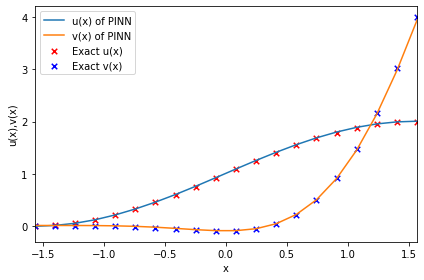

It: 5001, Loss: 4.528e-02  Losses ILRUDrxIC:[0.0066547575406730175, 0.02875518426299095, 0.009872185997664928]
It: 5002, Loss: 5.614e-02  Losses ILRUDrxIC:[0.011142895556986332, 0.03105725720524788, 0.013937576673924923]
It: 5003, Loss: 6.565e-02  Losses ILRUDrxIC:[0.010826325975358486, 0.04390924796462059, 0.010913152247667313]
It: 5004, Loss: 3.487e-02  Losses ILRUDrxIC:[0.0064848801121115685, 0.01721363700926304, 0.01116717979311943]
It: 5005, Loss: 6.693e-02  Losses ILRUDrxIC:[0.008461718447506428, 0.0428326353430748, 0.01563185639679432]
It: 5006, Loss: 7.644e-02  Losses ILRUDrxIC:[0.008699840866029263, 0.05596304312348366, 0.01177537627518177]
It: 5007, Loss: 4.525e-02  Losses ILRUDrxIC:[0.006653451360762119, 0.028732867911458015, 0.009866454638540745]
It: 5008, Loss: 5.612e-02  Losses ILRUDrxIC:[0.011137072928249836, 0.03105129487812519, 0.013929939828813076]
It: 5009, Loss: 6.562e-02  Losses ILRUDrxIC:[0.010821260511875153, 0.04389486089348793, 0.010905991308391094]
It: 5010, L

It: 5076, Loss: 3.476e-02  Losses ILRUDrxIC:[0.006474452558904886, 0.017196007072925568, 0.011084647849202156]
It: 5077, Loss: 6.644e-02  Losses ILRUDrxIC:[0.008413203991949558, 0.042511679232120514, 0.015519369393587112]
It: 5078, Loss: 7.588e-02  Losses ILRUDrxIC:[0.008658364415168762, 0.05554760992527008, 0.011676976457238197]
It: 5079, Loss: 4.491e-02  Losses ILRUDrxIC:[0.0066375043243169785, 0.028482822701334953, 0.009793822653591633]
It: 5080, Loss: 5.587e-02  Losses ILRUDrxIC:[0.011067362502217293, 0.030970580875873566, 0.013834835030138493]
It: 5081, Loss: 6.530e-02  Losses ILRUDrxIC:[0.010761294513940811, 0.04371943697333336, 0.010818473994731903]
It: 5082, Loss: 3.475e-02  Losses ILRUDrxIC:[0.0064734420739114285, 0.017194118350744247, 0.011077995412051678]
It: 5083, Loss: 6.641e-02  Losses ILRUDrxIC:[0.008409366011619568, 0.04248608648777008, 0.015510317869484425]
It: 5084, Loss: 7.584e-02  Losses ILRUDrxIC:[0.008654901757836342, 0.055514443665742874, 0.011669112369418144]
It

It: 5151, Loss: 4.459e-02  Losses ILRUDrxIC:[0.006622714456170797, 0.02824193239212036, 0.009725816547870636]
It: 5152, Loss: 5.564e-02  Losses ILRUDrxIC:[0.010999832302331924, 0.030894573777914047, 0.013743462972342968]
It: 5153, Loss: 6.499e-02  Losses ILRUDrxIC:[0.010703411884605885, 0.043552279472351074, 0.010731959715485573]
It: 5154, Loss: 3.464e-02  Losses ILRUDrxIC:[0.0064639863558113575, 0.017178524285554886, 0.010999658145010471]
It: 5155, Loss: 6.594e-02  Losses ILRUDrxIC:[0.008362265303730965, 0.04217807203531265, 0.015402459539473057]
It: 5156, Loss: 7.530e-02  Losses ILRUDrxIC:[0.008614955469965935, 0.05511491745710373, 0.011572221294045448]
It: 5157, Loss: 4.456e-02  Losses ILRUDrxIC:[0.0066214194521307945, 0.028221620246767998, 0.009719609282910824]
It: 5158, Loss: 5.562e-02  Losses ILRUDrxIC:[0.010994087904691696, 0.03088890202343464, 0.013735639862716198]
It: 5159, Loss: 6.496e-02  Losses ILRUDrxIC:[0.010698406957089901, 0.04353936389088631, 0.010724936611950397]
It: 

It: 5226, Loss: 3.454e-02  Losses ILRUDrxIC:[0.006454318296164274, 0.017164237797260284, 0.010924546048045158]
It: 5227, Loss: 6.550e-02  Losses ILRUDrxIC:[0.008316466584801674, 0.04188159853219986, 0.015298178419470787]
It: 5228, Loss: 7.478e-02  Losses ILRUDrxIC:[0.008576531894505024, 0.054730989038944244, 0.011476777493953705]
It: 5229, Loss: 4.425e-02  Losses ILRUDrxIC:[0.006607196293771267, 0.027990877628326416, 0.00965448934584856]
It: 5230, Loss: 5.539e-02  Losses ILRUDrxIC:[0.01092852558940649, 0.030816057696938515, 0.013647347688674927]
It: 5231, Loss: 6.466e-02  Losses ILRUDrxIC:[0.01064234133809805, 0.04337920621037483, 0.010639063082635403]
It: 5232, Loss: 3.453e-02  Losses ILRUDrxIC:[0.006453555077314377, 0.01716293767094612, 0.010918164625763893]
It: 5233, Loss: 6.546e-02  Losses ILRUDrxIC:[0.008312499150633812, 0.04185733199119568, 0.015288818627595901]
It: 5234, Loss: 7.474e-02  Losses ILRUDrxIC:[0.00857300590723753, 0.054699186235666275, 0.011468545533716679]
It: 5235,

It: 5301, Loss: 4.395e-02  Losses ILRUDrxIC:[0.006593698635697365, 0.027766628190875053, 0.009591545909643173]
It: 5302, Loss: 5.517e-02  Losses ILRUDrxIC:[0.010864483192563057, 0.030747950077056885, 0.01356221828609705]
It: 5303, Loss: 6.437e-02  Losses ILRUDrxIC:[0.010587926022708416, 0.04322728514671326, 0.010554066859185696]
It: 5304, Loss: 3.444e-02  Losses ILRUDrxIC:[0.006444503087550402, 0.017151033505797386, 0.010846330784261227]
It: 5305, Loss: 6.503e-02  Losses ILRUDrxIC:[0.008267824538052082, 0.04157179221510887, 0.01518859714269638]
It: 5306, Loss: 7.424e-02  Losses ILRUDrxIC:[0.008536082692444324, 0.05432945117354393, 0.011374427936971188]
It: 5307, Loss: 4.393e-02  Losses ILRUDrxIC:[0.006592556834220886, 0.02774834632873535, 0.009586524218320847]
It: 5308, Loss: 5.516e-02  Losses ILRUDrxIC:[0.0108591727912426, 0.03074272722005844, 0.01355481706559658]
It: 5309, Loss: 6.435e-02  Losses ILRUDrxIC:[0.010583190247416496, 0.04321454465389252, 0.010547838173806667]
It: 5310, Lo

It: 5376, Loss: 3.435e-02  Losses ILRUDrxIC:[0.00643538311123848, 0.017139067873358727, 0.010777341201901436]
It: 5377, Loss: 6.461e-02  Losses ILRUDrxIC:[0.008224026300013065, 0.041296884417533875, 0.015090618282556534]
It: 5378, Loss: 7.375e-02  Losses ILRUDrxIC:[0.008500071242451668, 0.05397326499223709, 0.01128146518021822]
It: 5379, Loss: 4.364e-02  Losses ILRUDrxIC:[0.006579555571079254, 0.027533438056707382, 0.009526938199996948]
It: 5380, Loss: 5.495e-02  Losses ILRUDrxIC:[0.010796982795000076, 0.030676843598484993, 0.013472005724906921]
It: 5381, Loss: 6.406e-02  Losses ILRUDrxIC:[0.010530387051403522, 0.04306827858090401, 0.01046342495828867]
It: 5382, Loss: 3.434e-02  Losses ILRUDrxIC:[0.0064345779828727245, 0.01713837869465351, 0.01077172253280878]
It: 5383, Loss: 6.458e-02  Losses ILRUDrxIC:[0.008220534771680832, 0.04127486050128937, 0.01508263684809208]
It: 5384, Loss: 7.372e-02  Losses ILRUDrxIC:[0.008497280068695545, 0.053945183753967285, 0.011274057440459728]
It: 5385,

It: 5451, Loss: 4.336e-02  Losses ILRUDrxIC:[0.006566408555954695, 0.02732805721461773, 0.009468991309404373]
It: 5452, Loss: 5.474e-02  Losses ILRUDrxIC:[0.010735642164945602, 0.030611442402005196, 0.013390930369496346]
It: 5453, Loss: 6.378e-02  Losses ILRUDrxIC:[0.010478629730641842, 0.04292451962828636, 0.010380432941019535]
It: 5454, Loss: 3.426e-02  Losses ILRUDrxIC:[0.0064254989847540855, 0.017125416547060013, 0.0107047688215971]
It: 5455, Loss: 6.418e-02  Losses ILRUDrxIC:[0.008177575655281544, 0.04101128503680229, 0.014986795373260975]
It: 5456, Loss: 7.325e-02  Losses ILRUDrxIC:[0.008462217636406422, 0.05360206216573715, 0.01118171401321888]
It: 5457, Loss: 4.334e-02  Losses ILRUDrxIC:[0.006565356161445379, 0.027310777455568314, 0.009464189410209656]
It: 5458, Loss: 5.472e-02  Losses ILRUDrxIC:[0.010730774141848087, 0.030606474727392197, 0.013384558260440826]
It: 5459, Loss: 6.376e-02  Losses ILRUDrxIC:[0.010474623180925846, 0.04291346296668053, 0.010373403318226337]
It: 5460

It: 5526, Loss: 3.417e-02  Losses ILRUDrxIC:[0.0064165834337472916, 0.017115257680416107, 0.010640604421496391]
It: 5527, Loss: 6.379e-02  Losses ILRUDrxIC:[0.008135339245200157, 0.040754977613687515, 0.014894749037921429]
It: 5528, Loss: 7.279e-02  Losses ILRUDrxIC:[0.008428270928561687, 0.053269773721694946, 0.011091315187513828]
It: 5529, Loss: 4.307e-02  Losses ILRUDrxIC:[0.006552811246365309, 0.027111003175377846, 0.009408673271536827]
It: 5530, Loss: 5.452e-02  Losses ILRUDrxIC:[0.010671091265976429, 0.03054511547088623, 0.01330608781427145]
It: 5531, Loss: 6.349e-02  Losses ILRUDrxIC:[0.010424376465380192, 0.0427766889333725, 0.010291444137692451]
It: 5532, Loss: 3.417e-02  Losses ILRUDrxIC:[0.006416016723960638, 0.01711476780474186, 0.010635250248014927]
It: 5533, Loss: 6.375e-02  Losses ILRUDrxIC:[0.008131922222673893, 0.040734659880399704, 0.014887282624840736]
It: 5534, Loss: 7.275e-02  Losses ILRUDrxIC:[0.008425755426287651, 0.053243692964315414, 0.011084486730396748]
It: 5

It: 5601, Loss: 4.281e-02  Losses ILRUDrxIC:[0.0065397764556109905, 0.02692052721977234, 0.009354396723210812]
It: 5602, Loss: 5.432e-02  Losses ILRUDrxIC:[0.010611976496875286, 0.03048291988670826, 0.013228925876319408]
It: 5603, Loss: 6.323e-02  Losses ILRUDrxIC:[0.010374780744314194, 0.04264235123991966, 0.010210900567471981]
It: 5604, Loss: 3.408e-02  Losses ILRUDrxIC:[0.006406544242054224, 0.017102912068367004, 0.010572637431323528]
It: 5605, Loss: 6.338e-02  Losses ILRUDrxIC:[0.008090385235846043, 0.040489036589860916, 0.014795923605561256]
It: 5606, Loss: 7.231e-02  Losses ILRUDrxIC:[0.008392447605729103, 0.052925340831279755, 0.01099501270800829]
It: 5607, Loss: 4.279e-02  Losses ILRUDrxIC:[0.006538503337651491, 0.026906244456768036, 0.009349912405014038]
It: 5608, Loss: 5.431e-02  Losses ILRUDrxIC:[0.010607107542455196, 0.030476098880171776, 0.013222409412264824]
It: 5609, Loss: 6.320e-02  Losses ILRUDrxIC:[0.010370736941695213, 0.042629875242710114, 0.01020345464348793]
It: 5

It: 5676, Loss: 3.400e-02  Losses ILRUDrxIC:[0.006397336721420288, 0.017092201858758926, 0.010512062348425388]
It: 5677, Loss: 6.301e-02  Losses ILRUDrxIC:[0.00804920308291912, 0.04025021567940712, 0.014707322232425213]
It: 5678, Loss: 7.188e-02  Losses ILRUDrxIC:[0.008360104635357857, 0.05261513963341713, 0.010906599462032318]
It: 5679, Loss: 4.254e-02  Losses ILRUDrxIC:[0.006525946315377951, 0.026720130816102028, 0.009297996759414673]
It: 5680, Loss: 5.411e-02  Losses ILRUDrxIC:[0.010549146682024002, 0.03041803278028965, 0.013147189281880856]
It: 5681, Loss: 6.295e-02  Losses ILRUDrxIC:[0.010322616435587406, 0.04250182583928108, 0.01012373622506857]
It: 5682, Loss: 3.400e-02  Losses ILRUDrxIC:[0.006396780721843243, 0.017091795802116394, 0.010506929829716682]
It: 5683, Loss: 6.298e-02  Losses ILRUDrxIC:[0.008045652881264687, 0.040230561047792435, 0.014700012281537056]
It: 5684, Loss: 7.185e-02  Losses ILRUDrxIC:[0.008357148617506027, 0.05259012430906296, 0.010899544693529606]
It: 5685

It: 5751, Loss: 4.230e-02  Losses ILRUDrxIC:[0.006512627005577087, 0.026543714106082916, 0.009247133508324623]
It: 5752, Loss: 5.392e-02  Losses ILRUDrxIC:[0.010491905733942986, 0.030356865376234055, 0.013073142617940903]
It: 5753, Loss: 6.269e-02  Losses ILRUDrxIC:[0.01027492806315422, 0.0423731654882431, 0.010044465772807598]
It: 5754, Loss: 3.391e-02  Losses ILRUDrxIC:[0.006386901251971722, 0.01707906275987625, 0.010448281653225422]
It: 5755, Loss: 6.262e-02  Losses ILRUDrxIC:[0.00800520833581686, 0.040002062916755676, 0.014613214880228043]
It: 5756, Loss: 7.143e-02  Losses ILRUDrxIC:[0.008325598202645779, 0.052292600274086, 0.01081235520541668]
It: 5757, Loss: 4.228e-02  Losses ILRUDrxIC:[0.006511666812002659, 0.026529202237725258, 0.009242864325642586]
It: 5758, Loss: 5.391e-02  Losses ILRUDrxIC:[0.010487258434295654, 0.030351927503943443, 0.013067134656012058]
It: 5759, Loss: 6.267e-02  Losses ILRUDrxIC:[0.010271106846630573, 0.04236273467540741, 0.010037178173661232]
It: 5760, L

It: 5826, Loss: 3.384e-02  Losses ILRUDrxIC:[0.006377224810421467, 0.017069896683096886, 0.010391236282885075]
It: 5827, Loss: 6.227e-02  Losses ILRUDrxIC:[0.00796478521078825, 0.039777129888534546, 0.014528417028486729]
It: 5828, Loss: 7.102e-02  Losses ILRUDrxIC:[0.008293967694044113, 0.05200067535042763, 0.010726646520197392]
It: 5829, Loss: 4.205e-02  Losses ILRUDrxIC:[0.006498596165329218, 0.02635478787124157, 0.009193992242217064]
It: 5830, Loss: 5.372e-02  Losses ILRUDrxIC:[0.010431083850562572, 0.030295608565211296, 0.012995573692023754]
It: 5831, Loss: 6.243e-02  Losses ILRUDrxIC:[0.010224570520222187, 0.04224134236574173, 0.009959573857486248]
It: 5832, Loss: 3.383e-02  Losses ILRUDrxIC:[0.0063764788210392, 0.017069615423679352, 0.010385544039309025]
It: 5833, Loss: 6.224e-02  Losses ILRUDrxIC:[0.007961568422615528, 0.039758969098329544, 0.014521612785756588]
It: 5834, Loss: 7.099e-02  Losses ILRUDrxIC:[0.008291871286928654, 0.05197867751121521, 0.010719874873757362]
It: 5835

It: 5901, Loss: 4.182e-02  Losses ILRUDrxIC:[0.00648520840331912, 0.026189502328634262, 0.009145572781562805]
It: 5902, Loss: 5.354e-02  Losses ILRUDrxIC:[0.010374875739216805, 0.03023681975901127, 0.012924110516905785]
It: 5903, Loss: 6.218e-02  Losses ILRUDrxIC:[0.010178213939070702, 0.04211907088756561, 0.009881491772830486]
It: 5904, Loss: 3.375e-02  Losses ILRUDrxIC:[0.006366260815411806, 0.01705714873969555, 0.010329433716833591]
It: 5905, Loss: 6.190e-02  Losses ILRUDrxIC:[0.007921267300844193, 0.03954368829727173, 0.014437657780945301]
It: 5906, Loss: 7.059e-02  Losses ILRUDrxIC:[0.008260607719421387, 0.051698654890060425, 0.010634965263307095]
It: 5907, Loss: 4.180e-02  Losses ILRUDrxIC:[0.006483805365860462, 0.026177765801548958, 0.009141567163169384]
It: 5908, Loss: 5.352e-02  Losses ILRUDrxIC:[0.010370174422860146, 0.030230218544602394, 0.012918153777718544]
It: 5909, Loss: 6.216e-02  Losses ILRUDrxIC:[0.010174530558288097, 0.0421074777841568, 0.009875395335257053]
It: 5910

It: 5976, Loss: 3.368e-02  Losses ILRUDrxIC:[0.006355807185173035, 0.017044780775904655, 0.01027451641857624]
It: 5977, Loss: 6.157e-02  Losses ILRUDrxIC:[0.007881294004619122, 0.039334531873464584, 0.014354841783642769]
It: 5978, Loss: 7.021e-02  Losses ILRUDrxIC:[0.008229898288846016, 0.051426853984594345, 0.010550951585173607]
It: 5979, Loss: 4.158e-02  Losses ILRUDrxIC:[0.00646980619058013, 0.02601836435496807, 0.0090949647128582]
It: 5980, Loss: 5.333e-02  Losses ILRUDrxIC:[0.01031482219696045, 0.030171822756528854, 0.012847771868109703]
It: 5981, Loss: 6.192e-02  Losses ILRUDrxIC:[0.010128963738679886, 0.04198812320828438, 0.00979834794998169]
It: 5982, Loss: 3.367e-02  Losses ILRUDrxIC:[0.00635475805029273, 0.017042862251400948, 0.010269743390381336]
It: 5983, Loss: 6.154e-02  Losses ILRUDrxIC:[0.007878067903220654, 0.039317939430475235, 0.014347704127430916]
It: 5984, Loss: 7.017e-02  Losses ILRUDrxIC:[0.008227575570344925, 0.051404375582933426, 0.010543012991547585]
It: 5985, 

It: 6051, Loss: 4.137e-02  Losses ILRUDrxIC:[0.006456044502556324, 0.02586272917687893, 0.009049147367477417]
It: 6052, Loss: 5.315e-02  Losses ILRUDrxIC:[0.010259609669446945, 0.030114151537418365, 0.012778990902006626]
It: 6053, Loss: 6.168e-02  Losses ILRUDrxIC:[0.01008392870426178, 0.04187101870775223, 0.009722469374537468]
It: 6054, Loss: 3.359e-02  Losses ILRUDrxIC:[0.006344340275973082, 0.017030911520123482, 0.010216305032372475]
It: 6055, Loss: 6.122e-02  Losses ILRUDrxIC:[0.007837923243641853, 0.0391143374145031, 0.014266821555793285]
It: 6056, Loss: 6.980e-02  Losses ILRUDrxIC:[0.008197065442800522, 0.05114045739173889, 0.010460256598889828]
It: 6057, Loss: 4.135e-02  Losses ILRUDrxIC:[0.00645493296906352, 0.025850199162960052, 0.009045429527759552]
It: 6058, Loss: 5.314e-02  Losses ILRUDrxIC:[0.010255102999508381, 0.030109543353319168, 0.012773306109011173]
It: 6059, Loss: 6.166e-02  Losses ILRUDrxIC:[0.010080240666866302, 0.04186161234974861, 0.009716169908642769]
It: 6060,

It: 6126, Loss: 3.352e-02  Losses ILRUDrxIC:[0.006333205848932266, 0.017019324004650116, 0.010163722559809685]
It: 6127, Loss: 6.090e-02  Losses ILRUDrxIC:[0.007798139005899429, 0.03891567513346672, 0.014187666587531567]
It: 6128, Loss: 6.943e-02  Losses ILRUDrxIC:[0.008167147636413574, 0.05088159069418907, 0.010378099977970123]
It: 6129, Loss: 4.114e-02  Losses ILRUDrxIC:[0.0064408257603645325, 0.025697937235236168, 0.009000583551824093]
It: 6130, Loss: 5.296e-02  Losses ILRUDrxIC:[0.010200564749538898, 0.030053898692131042, 0.012706119567155838]
It: 6131, Loss: 6.143e-02  Losses ILRUDrxIC:[0.01003585010766983, 0.04174784943461418, 0.009641334414482117]
It: 6132, Loss: 3.351e-02  Losses ILRUDrxIC:[0.00633262051269412, 0.017019156366586685, 0.010158708319067955]
It: 6133, Loss: 6.087e-02  Losses ILRUDrxIC:[0.0077944668009877205, 0.03889929875731468, 0.014180411584675312]
It: 6134, Loss: 6.940e-02  Losses ILRUDrxIC:[0.008164147846400738, 0.050861623138189316, 0.01037241518497467]
It: 61

It: 6201, Loss: 4.094e-02  Losses ILRUDrxIC:[0.006425707601010799, 0.02555442787706852, 0.008957180194556713]
It: 6202, Loss: 5.278e-02  Losses ILRUDrxIC:[0.010145867243409157, 0.02999444492161274, 0.012638602405786514]
It: 6203, Loss: 6.119e-02  Losses ILRUDrxIC:[0.009991304017603397, 0.04163246974349022, 0.009566615335643291]
It: 6204, Loss: 3.343e-02  Losses ILRUDrxIC:[0.0063207754865288734, 0.017004860565066338, 0.01010724063962698]
It: 6205, Loss: 6.056e-02  Losses ILRUDrxIC:[0.007754693739116192, 0.038707803934812546, 0.014101177453994751]
It: 6206, Loss: 6.904e-02  Losses ILRUDrxIC:[0.008134128525853157, 0.05061181262135506, 0.010290276259183884]
It: 6207, Loss: 4.092e-02  Losses ILRUDrxIC:[0.006424336228519678, 0.025541970506310463, 0.008953485637903214]
It: 6208, Loss: 5.276e-02  Losses ILRUDrxIC:[0.010141395032405853, 0.029990537092089653, 0.012633007019758224]
It: 6209, Loss: 6.117e-02  Losses ILRUDrxIC:[0.009987602941691875, 0.04162416607141495, 0.009560572914779186]
It: 62

It: 6276, Loss: 3.336e-02  Losses ILRUDrxIC:[0.006308790761977434, 0.016993066295981407, 0.010056544095277786]
It: 6277, Loss: 6.026e-02  Losses ILRUDrxIC:[0.007714597042649984, 0.03851952403783798, 0.014023477211594582]
It: 6278, Loss: 6.868e-02  Losses ILRUDrxIC:[0.008104021660983562, 0.0503682978451252, 0.010210125707089901]
It: 6279, Loss: 4.072e-02  Losses ILRUDrxIC:[0.006409064866602421, 0.0254011619836092, 0.008910922333598137]
It: 6280, Loss: 5.259e-02  Losses ILRUDrxIC:[0.010087082162499428, 0.02993241511285305, 0.012567084282636642]
It: 6281, Loss: 6.094e-02  Losses ILRUDrxIC:[0.009943538345396519, 0.04151145741343498, 0.009487425908446312]
It: 6282, Loss: 3.335e-02  Losses ILRUDrxIC:[0.0063074869103729725, 0.016990575939416885, 0.010052123107016087]
It: 6283, Loss: 6.023e-02  Losses ILRUDrxIC:[0.007711469661444426, 0.03850516676902771, 0.014016851782798767]
It: 6284, Loss: 6.865e-02  Losses ILRUDrxIC:[0.008101626299321651, 0.05034909024834633, 0.010203317739069462]
It: 6285,

It: 6351, Loss: 4.053e-02  Losses ILRUDrxIC:[0.006393444258719683, 0.02526330016553402, 0.00886937603354454]
It: 6352, Loss: 5.241e-02  Losses ILRUDrxIC:[0.010032981634140015, 0.02987668849527836, 0.012501544319093227]
It: 6353, Loss: 6.072e-02  Losses ILRUDrxIC:[0.009899920783936977, 0.04140257090330124, 0.0094141298905015]
It: 6354, Loss: 3.328e-02  Losses ILRUDrxIC:[0.006295518018305302, 0.016978349536657333, 0.010002647526562214]
It: 6355, Loss: 5.993e-02  Losses ILRUDrxIC:[0.00767107680439949, 0.03832129016518593, 0.013939968310296535]
It: 6356, Loss: 6.830e-02  Losses ILRUDrxIC:[0.00807163305580616, 0.05010967701673508, 0.010123105719685555]
It: 6357, Loss: 4.051e-02  Losses ILRUDrxIC:[0.00639241561293602, 0.02525147795677185, 0.008865793235599995]
It: 6358, Loss: 5.240e-02  Losses ILRUDrxIC:[0.01002848707139492, 0.029872512444853783, 0.01249643787741661]
It: 6359, Loss: 6.070e-02  Losses ILRUDrxIC:[0.009896108880639076, 0.0413937084376812, 0.009408298879861832]
It: 6360, Loss: 3

It: 6426, Loss: 3.320e-02  Losses ILRUDrxIC:[0.0062823849730193615, 0.01696508377790451, 0.0099538154900074]
It: 6427, Loss: 5.964e-02  Losses ILRUDrxIC:[0.0076308599673211575, 0.03814278170466423, 0.01386389508843422]
It: 6428, Loss: 6.796e-02  Losses ILRUDrxIC:[0.008041564375162125, 0.0498783215880394, 0.010044685564935207]
It: 6429, Loss: 4.032e-02  Losses ILRUDrxIC:[0.006376114208251238, 0.02511896751821041, 0.008825439028441906]
It: 6430, Loss: 5.222e-02  Losses ILRUDrxIC:[0.009974459186196327, 0.02981461025774479, 0.012432219460606575]
It: 6431, Loss: 6.047e-02  Losses ILRUDrxIC:[0.009852548129856586, 0.041284188628196716, 0.00933636911213398]
It: 6432, Loss: 3.319e-02  Losses ILRUDrxIC:[0.0062815044075250626, 0.016962673515081406, 0.009949437342584133]
It: 6433, Loss: 5.961e-02  Losses ILRUDrxIC:[0.007627463899552822, 0.038129132241010666, 0.013857519254088402]
It: 6434, Loss: 6.794e-02  Losses ILRUDrxIC:[0.008039086125791073, 0.04985974356532097, 0.010038037784397602]
It: 6435,

It: 6501, Loss: 4.013e-02  Losses ILRUDrxIC:[0.006359650753438473, 0.024989843368530273, 0.00878507737070322]
It: 6502, Loss: 5.205e-02  Losses ILRUDrxIC:[0.009920291602611542, 0.029757672920823097, 0.012368457391858101]
It: 6503, Loss: 6.025e-02  Losses ILRUDrxIC:[0.009808914735913277, 0.04117721691727638, 0.009265109896659851]
It: 6504, Loss: 3.312e-02  Losses ILRUDrxIC:[0.006268569268286228, 0.016949230805039406, 0.009901521727442741]
It: 6505, Loss: 5.932e-02  Losses ILRUDrxIC:[0.007586747873574495, 0.03795456513762474, 0.013782466761767864]
It: 6506, Loss: 6.760e-02  Losses ILRUDrxIC:[0.008008841425180435, 0.049632392823696136, 0.009960156865417957]
It: 6507, Loss: 4.012e-02  Losses ILRUDrxIC:[0.006358676590025425, 0.024977590888738632, 0.008781775832176208]
It: 6508, Loss: 5.203e-02  Losses ILRUDrxIC:[0.009915829636156559, 0.029754845425486565, 0.012363153509795666]
It: 6509, Loss: 6.024e-02  Losses ILRUDrxIC:[0.009805376641452312, 0.04117003083229065, 0.00925964955240488]
It: 65

It: 6576, Loss: 3.305e-02  Losses ILRUDrxIC:[0.006254823878407478, 0.016936369240283966, 0.009853813797235489]
It: 6577, Loss: 5.904e-02  Losses ILRUDrxIC:[0.007545679807662964, 0.03778398782014847, 0.013708166778087616]
It: 6578, Loss: 6.727e-02  Losses ILRUDrxIC:[0.007978379726409912, 0.049411192536354065, 0.00988312903791666]
It: 6579, Loss: 3.994e-02  Losses ILRUDrxIC:[0.006341550033539534, 0.024851983413100243, 0.0087426220998168]
It: 6580, Loss: 5.186e-02  Losses ILRUDrxIC:[0.009861590340733528, 0.02969694323837757, 0.012300263158977032]
It: 6581, Loss: 6.001e-02  Losses ILRUDrxIC:[0.00976151879876852, 0.04106283187866211, 0.009189116768538952]
It: 6582, Loss: 3.304e-02  Losses ILRUDrxIC:[0.006253466475754976, 0.01693485863506794, 0.00985033717006445]
It: 6583, Loss: 5.901e-02  Losses ILRUDrxIC:[0.007542366161942482, 0.037769634276628494, 0.013701962307095528]
It: 6584, Loss: 6.724e-02  Losses ILRUDrxIC:[0.007975741289556026, 0.04939226061105728, 0.009876543655991554]
It: 6585, L

It: 6651, Loss: 3.976e-02  Losses ILRUDrxIC:[0.006324089132249355, 0.02472890540957451, 0.008704290725290775]
It: 6652, Loss: 5.169e-02  Losses ILRUDrxIC:[0.009807637892663479, 0.029640141874551773, 0.012238381430506706]
It: 6653, Loss: 5.980e-02  Losses ILRUDrxIC:[0.00971817597746849, 0.04095730558037758, 0.009120140224695206]
It: 6654, Loss: 3.296e-02  Losses ILRUDrxIC:[0.0062393066473305225, 0.016919497400522232, 0.009803453460335732]
It: 6655, Loss: 5.873e-02  Losses ILRUDrxIC:[0.007501281797885895, 0.03760393336415291, 0.013628093525767326]
It: 6656, Loss: 6.692e-02  Losses ILRUDrxIC:[0.007945195771753788, 0.04917607083916664, 0.009799791499972343]
It: 6657, Loss: 3.974e-02  Losses ILRUDrxIC:[0.006322591099888086, 0.024717742577195168, 0.008701215498149395]
It: 6658, Loss: 5.167e-02  Losses ILRUDrxIC:[0.009803401306271553, 0.029637068510055542, 0.012232995592057705]
It: 6659, Loss: 5.978e-02  Losses ILRUDrxIC:[0.009714632295072079, 0.04095020890235901, 0.009113715030252934]
It: 66

It: 6726, Loss: 3.289e-02  Losses ILRUDrxIC:[0.00622514309361577, 0.016906341537833214, 0.009757541120052338]
It: 6727, Loss: 5.846e-02  Losses ILRUDrxIC:[0.007459798362106085, 0.037440136075019836, 0.013555862940847874]
It: 6728, Loss: 6.660e-02  Losses ILRUDrxIC:[0.007914766669273376, 0.04896339401602745, 0.009724076837301254]
It: 6729, Loss: 3.957e-02  Losses ILRUDrxIC:[0.006304970942437649, 0.024597179144620895, 0.008663284592330456]
It: 6730, Loss: 5.150e-02  Losses ILRUDrxIC:[0.009749198332428932, 0.029581090435385704, 0.012171899899840355]
It: 6731, Loss: 5.956e-02  Losses ILRUDrxIC:[0.009671168401837349, 0.04084742069244385, 0.009044515900313854]
It: 6732, Loss: 3.288e-02  Losses ILRUDrxIC:[0.006223913282155991, 0.016906259581446648, 0.009754031896591187]
It: 6733, Loss: 5.843e-02  Losses ILRUDrxIC:[0.007456423714756966, 0.037425633519887924, 0.013550090603530407]
It: 6734, Loss: 6.658e-02  Losses ILRUDrxIC:[0.007912320084869862, 0.048944659531116486, 0.009718355722725391]
It: 

It: 6801, Loss: 3.939e-02  Losses ILRUDrxIC:[0.006287116091698408, 0.0244784913957119, 0.008625837042927742]
It: 6802, Loss: 5.133e-02  Losses ILRUDrxIC:[0.009694942273199558, 0.029526343569159508, 0.012110992334783077]
It: 6803, Loss: 5.935e-02  Losses ILRUDrxIC:[0.009627735242247581, 0.04074639081954956, 0.008976706303656101]
It: 6804, Loss: 3.281e-02  Losses ILRUDrxIC:[0.006209192797541618, 0.016892140731215477, 0.00970880500972271]
It: 6805, Loss: 5.816e-02  Losses ILRUDrxIC:[0.00741439126431942, 0.03726593032479286, 0.013477961532771587]
It: 6806, Loss: 6.626e-02  Losses ILRUDrxIC:[0.00788134802132845, 0.048737406730651855, 0.009643363766372204]
It: 6807, Loss: 3.938e-02  Losses ILRUDrxIC:[0.006285498850047588, 0.024469921365380287, 0.00862334854900837]
It: 6808, Loss: 5.132e-02  Losses ILRUDrxIC:[0.00969045888632536, 0.029520632699131966, 0.012106170877814293]
It: 6809, Loss: 5.933e-02  Losses ILRUDrxIC:[0.00962415523827076, 0.04073677584528923, 0.008971123024821281]
It: 6810, Lo

It: 6876, Loss: 3.273e-02  Losses ILRUDrxIC:[0.006193574983626604, 0.016876662150025368, 0.009664410725235939]
It: 6877, Loss: 5.789e-02  Losses ILRUDrxIC:[0.007372623775154352, 0.03710971772670746, 0.013406461104750633]
It: 6878, Loss: 6.595e-02  Losses ILRUDrxIC:[0.007850303314626217, 0.04853295907378197, 0.009568598121404648]
It: 6879, Loss: 3.921e-02  Losses ILRUDrxIC:[0.006266719661653042, 0.024354228749871254, 0.008587192744016647]
It: 6880, Loss: 5.115e-02  Losses ILRUDrxIC:[0.00963659305125475, 0.029466072097420692, 0.012046127580106258]
It: 6881, Loss: 5.912e-02  Losses ILRUDrxIC:[0.009581010788679123, 0.040637075901031494, 0.008903215639293194]
It: 6882, Loss: 3.273e-02  Losses ILRUDrxIC:[0.006192509084939957, 0.016877034679055214, 0.009660974144935608]
It: 6883, Loss: 5.787e-02  Losses ILRUDrxIC:[0.007369121536612511, 0.037095192819833755, 0.013401051983237267]
It: 6884, Loss: 6.592e-02  Losses ILRUDrxIC:[0.007848120294511318, 0.04851391166448593, 0.009562158025801182]
It: 6

It: 7025, Loss: 5.870e-02  Losses ILRUDrxIC:[0.009494391269981861, 0.040440067648887634, 0.008770185522735119]
It: 7026, Loss: 3.258e-02  Losses ILRUDrxIC:[0.006161318626254797, 0.016848968341946602, 0.00957369152456522]
It: 7027, Loss: 5.733e-02  Losses ILRUDrxIC:[0.007283733692020178, 0.036789607256650925, 0.013261108659207821]
It: 7028, Loss: 6.532e-02  Losses ILRUDrxIC:[0.007785318419337273, 0.048115722835063934, 0.009415904060006142]
It: 7029, Loss: 3.886e-02  Losses ILRUDrxIC:[0.006227494683116674, 0.024119118228554726, 0.00851348415017128]
It: 7030, Loss: 5.080e-02  Losses ILRUDrxIC:[0.00952343363314867, 0.029353821650147438, 0.011923677287995815]
It: 7031, Loss: 5.869e-02  Losses ILRUDrxIC:[0.009490604512393475, 0.04043221101164818, 0.008764998987317085]
It: 7032, Loss: 3.258e-02  Losses ILRUDrxIC:[0.006159861572086811, 0.01684793271124363, 0.009570079855620861]
It: 7033, Loss: 5.731e-02  Losses ILRUDrxIC:[0.00728004053235054, 0.03677721321582794, 0.013255174271762371]
It: 7034

It: 7100, Loss: 6.502e-02  Losses ILRUDrxIC:[0.0077536082826554775, 0.04792279750108719, 0.009343666955828667]
It: 7101, Loss: 3.870e-02  Losses ILRUDrxIC:[0.00620758393779397, 0.02401178702712059, 0.00847966130822897]
It: 7102, Loss: 5.063e-02  Losses ILRUDrxIC:[0.009469065815210342, 0.029298387467861176, 0.011865352280437946]
It: 7103, Loss: 5.848e-02  Losses ILRUDrxIC:[0.00944706704467535, 0.040333718061447144, 0.008699681609869003]
It: 7104, Loss: 3.250e-02  Losses ILRUDrxIC:[0.006143283564597368, 0.016832776367664337, 0.009528074413537979]
It: 7105, Loss: 5.705e-02  Losses ILRUDrxIC:[0.007237170822918415, 0.03662905469536781, 0.013186011463403702]
It: 7106, Loss: 6.499e-02  Losses ILRUDrxIC:[0.0077512990683317184, 0.04790623486042023, 0.009337211959064007]
It: 7107, Loss: 3.869e-02  Losses ILRUDrxIC:[0.0062061152420938015, 0.02400210127234459, 0.008476856164634228]
It: 7108, Loss: 5.062e-02  Losses ILRUDrxIC:[0.009464628994464874, 0.029294544830918312, 0.011860924772918224]
It: 71

It: 7175, Loss: 5.828e-02  Losses ILRUDrxIC:[0.009403752163052559, 0.04023820534348488, 0.008634661324322224]
It: 7176, Loss: 3.243e-02  Losses ILRUDrxIC:[0.006126749329268932, 0.016818463802337646, 0.009486520662903786]
It: 7177, Loss: 5.679e-02  Losses ILRUDrxIC:[0.007193824741989374, 0.03648294508457184, 0.013117948547005653]
It: 7178, Loss: 6.470e-02  Losses ILRUDrxIC:[0.007719562388956547, 0.047715842723846436, 0.009265927597880363]
It: 7179, Loss: 3.853e-02  Losses ILRUDrxIC:[0.006186146754771471, 0.023896148428320885, 0.008443016558885574]
It: 7180, Loss: 5.045e-02  Losses ILRUDrxIC:[0.00941016897559166, 0.029239872470498085, 0.011803453788161278]
It: 7181, Loss: 5.826e-02  Losses ILRUDrxIC:[0.009400291368365288, 0.040229681879282, 0.008629501797258854]
It: 7182, Loss: 3.243e-02  Losses ILRUDrxIC:[0.006125357933342457, 0.01681721955537796, 0.009482582099735737]
It: 7183, Loss: 5.677e-02  Losses ILRUDrxIC:[0.007190104573965073, 0.0364709310233593, 0.013111853040754795]
It: 7184, 

It: 7250, Loss: 6.441e-02  Losses ILRUDrxIC:[0.007687301840633154, 0.04752645641565323, 0.009194739162921906]
It: 7251, Loss: 3.837e-02  Losses ILRUDrxIC:[0.006166112143546343, 0.02379034273326397, 0.008410202339291573]
It: 7252, Loss: 5.029e-02  Losses ILRUDrxIC:[0.009355580434203148, 0.02918715588748455, 0.011746306903660297]
It: 7253, Loss: 5.806e-02  Losses ILRUDrxIC:[0.009356767870485783, 0.040134966373443604, 0.008565428666770458]
It: 7254, Loss: 3.235e-02  Losses ILRUDrxIC:[0.006108387839049101, 0.01680322177708149, 0.00944199226796627]
It: 7255, Loss: 5.652e-02  Losses ILRUDrxIC:[0.007146385032683611, 0.03632665053009987, 0.013044198974967003]
It: 7256, Loss: 6.439e-02  Losses ILRUDrxIC:[0.007684729993343353, 0.04751153662800789, 0.009188861586153507]
It: 7257, Loss: 3.835e-02  Losses ILRUDrxIC:[0.006164173595607281, 0.023782629519701004, 0.008407729677855968]
It: 7258, Loss: 5.028e-02  Losses ILRUDrxIC:[0.009351253509521484, 0.0291821900755167, 0.01174196694046259]
It: 7259, L

It: 7325, Loss: 5.785e-02  Losses ILRUDrxIC:[0.009313562884926796, 0.040039900690317154, 0.008501402102410793]
It: 7326, Loss: 3.228e-02  Losses ILRUDrxIC:[0.006090803537517786, 0.016788234934210777, 0.00940082035958767]
It: 7327, Loss: 5.626e-02  Losses ILRUDrxIC:[0.0071026929654181, 0.03618490695953369, 0.012976953759789467]
It: 7328, Loss: 6.410e-02  Losses ILRUDrxIC:[0.007652865257114172, 0.04732602834701538, 0.009117716923356056]
It: 7329, Loss: 3.820e-02  Losses ILRUDrxIC:[0.006143358536064625, 0.023678526282310486, 0.008374761790037155]
It: 7330, Loss: 5.011e-02  Losses ILRUDrxIC:[0.00929686427116394, 0.029130084440112114, 0.011685129255056381]
It: 7331, Loss: 5.784e-02  Losses ILRUDrxIC:[0.009310017339885235, 0.040033068507909775, 0.008496223017573357]
It: 7332, Loss: 3.228e-02  Losses ILRUDrxIC:[0.0060894363559782505, 0.01678827777504921, 0.0093974769115448]
It: 7333, Loss: 5.624e-02  Losses ILRUDrxIC:[0.007098965346813202, 0.03617297485470772, 0.012971377931535244]
It: 7334, 

It: 7400, Loss: 6.381e-02  Losses ILRUDrxIC:[0.007620864547789097, 0.04714466631412506, 0.00904840137809515]
It: 7401, Loss: 3.804e-02  Losses ILRUDrxIC:[0.0061223069205880165, 0.02357921563088894, 0.008343365043401718]
It: 7402, Loss: 4.995e-02  Losses ILRUDrxIC:[0.009242400527000427, 0.029075128957629204, 0.011629262007772923]
It: 7403, Loss: 5.764e-02  Losses ILRUDrxIC:[0.009266738779842854, 0.03993853181600571, 0.008433802984654903]
It: 7404, Loss: 3.220e-02  Losses ILRUDrxIC:[0.0060714916326105595, 0.016772152855992317, 0.00935746356844902]
It: 7405, Loss: 5.599e-02  Losses ILRUDrxIC:[0.007055060006678104, 0.03603491187095642, 0.012904367409646511]
It: 7406, Loss: 6.379e-02  Losses ILRUDrxIC:[0.007618124596774578, 0.047129761427640915, 0.009042516350746155]
It: 7407, Loss: 3.803e-02  Losses ILRUDrxIC:[0.0061203716322779655, 0.02357078716158867, 0.008340582251548767]
It: 7408, Loss: 4.993e-02  Losses ILRUDrxIC:[0.009237918071448803, 0.029071001335978508, 0.011624487116932869]
It: 7

It: 7475, Loss: 5.744e-02  Losses ILRUDrxIC:[0.009223619475960732, 0.03984643518924713, 0.00837134663015604]
It: 7476, Loss: 3.213e-02  Losses ILRUDrxIC:[0.00605315575376153, 0.016758352518081665, 0.009318185038864613]
It: 7477, Loss: 5.575e-02  Losses ILRUDrxIC:[0.007010892033576965, 0.035896945744752884, 0.012837538495659828]
It: 7478, Loss: 6.351e-02  Losses ILRUDrxIC:[0.007585951127111912, 0.04694933071732521, 0.008972926996648312]
It: 7479, Loss: 3.788e-02  Losses ILRUDrxIC:[0.00609913794323802, 0.023470832034945488, 0.0083101661875844]
It: 7480, Loss: 4.977e-02  Losses ILRUDrxIC:[0.009183692745864391, 0.02901810221374035, 0.011568953283131123]
It: 7481, Loss: 5.742e-02  Losses ILRUDrxIC:[0.009220096282660961, 0.03983745351433754, 0.008365645073354244]
It: 7482, Loss: 3.212e-02  Losses ILRUDrxIC:[0.006051907781511545, 0.01675606146454811, 0.009315123781561852]
It: 7483, Loss: 5.573e-02  Losses ILRUDrxIC:[0.007007429376244545, 0.03588629141449928, 0.012832611799240112]
It: 7484, Lo

It: 7550, Loss: 6.323e-02  Losses ILRUDrxIC:[0.007553944829851389, 0.046773120760917664, 0.008904454298317432]
It: 7551, Loss: 3.773e-02  Losses ILRUDrxIC:[0.006077549420297146, 0.02337394468486309, 0.008279269561171532]
It: 7552, Loss: 4.961e-02  Losses ILRUDrxIC:[0.009129446931183338, 0.028965529054403305, 0.011513943783938885]
It: 7553, Loss: 5.723e-02  Losses ILRUDrxIC:[0.00917722750455141, 0.039746347814798355, 0.008304647170007229]
It: 7554, Loss: 3.205e-02  Losses ILRUDrxIC:[0.0060333856381475925, 0.016742775216698647, 0.009275891818106174]
It: 7555, Loss: 5.548e-02  Losses ILRUDrxIC:[0.006962879560887814, 0.0357506163418293, 0.012766272760927677]
It: 7556, Loss: 6.321e-02  Losses ILRUDrxIC:[0.007550980895757675, 0.04675775393843651, 0.008898922242224216]
It: 7557, Loss: 3.772e-02  Losses ILRUDrxIC:[0.006075537763535976, 0.023365652188658714, 0.008276316337287426]
It: 7558, Loss: 4.959e-02  Losses ILRUDrxIC:[0.009124843403697014, 0.028961293399333954, 0.011508694849908352]
It: 7

It: 7625, Loss: 5.703e-02  Losses ILRUDrxIC:[0.009134335443377495, 0.039655644446611404, 0.008243332616984844]
It: 7626, Loss: 3.198e-02  Losses ILRUDrxIC:[0.006014591548591852, 0.016728539019823074, 0.009237817488610744]
It: 7627, Loss: 5.524e-02  Losses ILRUDrxIC:[0.006918560713529587, 0.035616885870695114, 0.01270070020109415]
It: 7628, Loss: 6.293e-02  Losses ILRUDrxIC:[0.007518898695707321, 0.0465821772813797, 0.00883068423718214]
It: 7629, Loss: 3.757e-02  Losses ILRUDrxIC:[0.0060537043027579784, 0.02326844073832035, 0.008246812038123608]
It: 7630, Loss: 4.943e-02  Losses ILRUDrxIC:[0.009070961736142635, 0.028909768909215927, 0.011454088613390923]
It: 7631, Loss: 5.702e-02  Losses ILRUDrxIC:[0.00913074892014265, 0.03964803367853165, 0.008238578215241432]
It: 7632, Loss: 3.197e-02  Losses ILRUDrxIC:[0.006012822967022657, 0.01672697439789772, 0.009234863333404064]
It: 7633, Loss: 5.522e-02  Losses ILRUDrxIC:[0.006915086880326271, 0.03560652211308479, 0.012695292942225933]
It: 7634,

It: 7700, Loss: 6.266e-02  Losses ILRUDrxIC:[0.007486748043447733, 0.04641043767333031, 0.008763051591813564]
It: 7701, Loss: 3.742e-02  Losses ILRUDrxIC:[0.006031041964888573, 0.02317466214299202, 0.008217256516218185]
It: 7702, Loss: 4.927e-02  Losses ILRUDrxIC:[0.009017052128911018, 0.0288567915558815, 0.01139901764690876]
It: 7703, Loss: 5.682e-02  Losses ILRUDrxIC:[0.00908801518380642, 0.039556391537189484, 0.008178122341632843]
It: 7704, Loss: 3.190e-02  Losses ILRUDrxIC:[0.005993656814098358, 0.016711890697479248, 0.009196956641972065]
It: 7705, Loss: 5.498e-02  Losses ILRUDrxIC:[0.006870737299323082, 0.03547482192516327, 0.012629556469619274]
It: 7706, Loss: 6.264e-02  Losses ILRUDrxIC:[0.00748416967689991, 0.04639534652233124, 0.008757585659623146]
It: 7707, Loss: 3.741e-02  Losses ILRUDrxIC:[0.006029556971043348, 0.023166116327047348, 0.00821511261165142]
It: 7708, Loss: 4.926e-02  Losses ILRUDrxIC:[0.009012541733682156, 0.02885359525680542, 0.011394567787647247]
It: 7709, Lo

It: 7775, Loss: 5.663e-02  Losses ILRUDrxIC:[0.00904514268040657, 0.03946646302938461, 0.008118783123791218]
It: 7776, Loss: 3.183e-02  Losses ILRUDrxIC:[0.0059738801792263985, 0.01669706031680107, 0.009159992448985577]
It: 7777, Loss: 5.474e-02  Losses ILRUDrxIC:[0.006826639175415039, 0.03534547612071037, 0.012564104981720448]
It: 7778, Loss: 6.237e-02  Losses ILRUDrxIC:[0.007451911922544241, 0.04622664302587509, 0.008691230788826942]
It: 7779, Loss: 3.727e-02  Losses ILRUDrxIC:[0.006006680894643068, 0.023074885830283165, 0.008186525665223598]
It: 7780, Loss: 4.910e-02  Losses ILRUDrxIC:[0.008958913385868073, 0.028799355030059814, 0.011339857243001461]
It: 7781, Loss: 5.661e-02  Losses ILRUDrxIC:[0.009041732177138329, 0.03945823013782501, 0.008114157244563103]
It: 7782, Loss: 3.182e-02  Losses ILRUDrxIC:[0.005972322542220354, 0.016694847494363785, 0.00915679894387722]
It: 7783, Loss: 5.472e-02  Losses ILRUDrxIC:[0.006822978612035513, 0.03533509373664856, 0.01255837269127369]
It: 7784,

It: 7850, Loss: 6.210e-02  Losses ILRUDrxIC:[0.0074199954979121685, 0.04605792462825775, 0.00862456951290369]
It: 7851, Loss: 3.712e-02  Losses ILRUDrxIC:[0.005983901210129261, 0.022982697933912277, 0.008158246986567974]
It: 7852, Loss: 4.894e-02  Losses ILRUDrxIC:[0.008905617520213127, 0.028747517615556717, 0.011285724118351936]
It: 7853, Loss: 5.642e-02  Losses ILRUDrxIC:[0.008999387733638287, 0.03936868906021118, 0.008054975420236588]
It: 7854, Loss: 3.175e-02  Losses ILRUDrxIC:[0.005952480249106884, 0.01668013632297516, 0.009120147675275803]
It: 7855, Loss: 5.448e-02  Losses ILRUDrxIC:[0.006779229734092951, 0.03520684689283371, 0.012493615970015526]
It: 7856, Loss: 6.208e-02  Losses ILRUDrxIC:[0.007417358923703432, 0.046043917536735535, 0.008619546890258789]
It: 7857, Loss: 3.711e-02  Losses ILRUDrxIC:[0.005981781519949436, 0.022974763065576553, 0.008155621588230133]
It: 7858, Loss: 4.893e-02  Losses ILRUDrxIC:[0.008901210501790047, 0.028744058683514595, 0.011280921287834644]
It: 7

It: 7925, Loss: 5.623e-02  Losses ILRUDrxIC:[0.008957024663686752, 0.039280541241168976, 0.007996933534741402]
It: 7926, Loss: 3.168e-02  Losses ILRUDrxIC:[0.005931718274950981, 0.0166662335395813, 0.00908399187028408]
It: 7927, Loss: 5.424e-02  Losses ILRUDrxIC:[0.006735738832503557, 0.035079993307590485, 0.012428225949406624]
It: 7928, Loss: 6.182e-02  Losses ILRUDrxIC:[0.0073852743953466415, 0.04587697982788086, 0.00855416152626276]
It: 7929, Loss: 3.697e-02  Losses ILRUDrxIC:[0.00595841696485877, 0.022884096950292587, 0.008128659799695015]
It: 7930, Loss: 4.877e-02  Losses ILRUDrxIC:[0.008848458528518677, 0.028692087158560753, 0.01122659258544445]
It: 7931, Loss: 5.622e-02  Losses ILRUDrxIC:[0.008953803218901157, 0.03927271068096161, 0.007992584258317947]
It: 7932, Loss: 3.168e-02  Losses ILRUDrxIC:[0.0059303417801856995, 0.016664592549204826, 0.009080782532691956]
It: 7933, Loss: 5.422e-02  Losses ILRUDrxIC:[0.006732076406478882, 0.035070013254880905, 0.012422678992152214]
It: 793

It: 8000, Loss: 6.156e-02  Losses ILRUDrxIC:[0.007353285327553749, 0.045713573694229126, 0.008489623665809631]
It: 8001, Loss: 3.683e-02  Losses ILRUDrxIC:[0.005934965796768665, 0.02279580943286419, 0.008101298473775387]
It: 8002, Loss: 4.861e-02  Losses ILRUDrxIC:[0.008795786648988724, 0.02863948978483677, 0.011172164231538773]
It: 8003, Loss: 5.603e-02  Losses ILRUDrxIC:[0.008911565877497196, 0.039183709770441055, 0.007935761474072933]
It: 8004, Loss: 3.160e-02  Losses ILRUDrxIC:[0.005909353494644165, 0.01664920337498188, 0.009045187383890152]
It: 8005, Loss: 5.399e-02  Losses ILRUDrxIC:[0.006688654888421297, 0.03494524210691452, 0.012357469648122787]
It: 8006, Loss: 6.153e-02  Losses ILRUDrxIC:[0.007350832223892212, 0.04569973424077034, 0.008484206162393093]
It: 8007, Loss: 3.682e-02  Losses ILRUDrxIC:[0.005933099426329136, 0.022788699716329575, 0.008099313825368881]
It: 8008, Loss: 4.859e-02  Losses ILRUDrxIC:[0.008791512809693813, 0.02863502688705921, 0.011167893186211586]
It: 800

It: 8075, Loss: 5.585e-02  Losses ILRUDrxIC:[0.008870082907378674, 0.03909546881914139, 0.00788005068898201]
It: 8076, Loss: 3.153e-02  Losses ILRUDrxIC:[0.005888728890568018, 0.016633858904242516, 0.0090095279738307]
It: 8077, Loss: 5.376e-02  Losses ILRUDrxIC:[0.00664555374532938, 0.03482186794281006, 0.012292003259062767]
It: 8078, Loss: 6.128e-02  Losses ILRUDrxIC:[0.007318946998566389, 0.04553745314478874, 0.008420528843998909]
It: 8079, Loss: 3.668e-02  Losses ILRUDrxIC:[0.005909421946853399, 0.022700602188706398, 0.008072652854025364]
It: 8080, Loss: 4.844e-02  Losses ILRUDrxIC:[0.008739189244806767, 0.02858385257422924, 0.011113089509308338]
It: 8081, Loss: 5.583e-02  Losses ILRUDrxIC:[0.008866040967404842, 0.03908838331699371, 0.007875045761466026]
It: 8082, Loss: 3.153e-02  Losses ILRUDrxIC:[0.005886333528906107, 0.016632797196507454, 0.00900705810636282]
It: 8083, Loss: 5.374e-02  Losses ILRUDrxIC:[0.006642300635576248, 0.03481148183345795, 0.012286766432225704]
It: 8084, Lo

It: 8150, Loss: 6.102e-02  Losses ILRUDrxIC:[0.007287778425961733, 0.0453767329454422, 0.00835727620869875]
It: 8151, Loss: 3.655e-02  Losses ILRUDrxIC:[0.005885616410523653, 0.022614076733589172, 0.008046376518905163]
It: 8152, Loss: 4.828e-02  Losses ILRUDrxIC:[0.008687830530107021, 0.02853207290172577, 0.01105915941298008]
It: 8153, Loss: 5.565e-02  Losses ILRUDrxIC:[0.008824978955090046, 0.0390004962682724, 0.00782009307295084]
It: 8154, Loss: 3.145e-02  Losses ILRUDrxIC:[0.005865318700671196, 0.016617141664028168, 0.00897213350981474]
It: 8155, Loss: 5.351e-02  Losses ILRUDrxIC:[0.006599870044738054, 0.03468967601656914, 0.0122216260060668]
It: 8156, Loss: 6.100e-02  Losses ILRUDrxIC:[0.007285088300704956, 0.04536234587430954, 0.008352265693247318]
It: 8157, Loss: 3.653e-02  Losses ILRUDrxIC:[0.005883743520826101, 0.022606132552027702, 0.008044125512242317]
It: 8158, Loss: 4.827e-02  Losses ILRUDrxIC:[0.008683483116328716, 0.028528926894068718, 0.011054317466914654]
It: 8159, Loss

It: 8225, Loss: 5.546e-02  Losses ILRUDrxIC:[0.008783319033682346, 0.03891361132264137, 0.007766033988445997]
It: 8226, Loss: 3.138e-02  Losses ILRUDrxIC:[0.005843347404152155, 0.016601724550127983, 0.008938024751842022]
It: 8227, Loss: 5.328e-02  Losses ILRUDrxIC:[0.006558248307555914, 0.034568823873996735, 0.012156384065747261]
It: 8228, Loss: 6.075e-02  Losses ILRUDrxIC:[0.0072538782842457294, 0.04520294815301895, 0.008290388621389866]
It: 8229, Loss: 3.640e-02  Losses ILRUDrxIC:[0.005859492812305689, 0.02252030558884144, 0.00801849365234375]
It: 8230, Loss: 4.811e-02  Losses ILRUDrxIC:[0.00863261055201292, 0.02847730740904808, 0.011000007390975952]
It: 8231, Loss: 5.545e-02  Losses ILRUDrxIC:[0.008780124597251415, 0.03890597075223923, 0.007761684712022543]
It: 8232, Loss: 3.138e-02  Losses ILRUDrxIC:[0.0058418079279363155, 0.01660044677555561, 0.0089346244931221]
It: 8233, Loss: 5.326e-02  Losses ILRUDrxIC:[0.006554467603564262, 0.034558556973934174, 0.012150374241173267]
It: 8234,

It: 8300, Loss: 6.050e-02  Losses ILRUDrxIC:[0.007222634740173817, 0.04504476115107536, 0.008229486644268036]
It: 8301, Loss: 3.626e-02  Losses ILRUDrxIC:[0.005835391581058502, 0.022435519844293594, 0.007993568666279316]
It: 8302, Loss: 4.795e-02  Losses ILRUDrxIC:[0.008582117035984993, 0.0284262802451849, 0.010945790447294712]
It: 8303, Loss: 5.527e-02  Losses ILRUDrxIC:[0.008738800883293152, 0.03881916031241417, 0.007709270343184471]
It: 8304, Loss: 3.131e-02  Losses ILRUDrxIC:[0.0058194720186293125, 0.016584916040301323, 0.008901132270693779]
It: 8305, Loss: 5.304e-02  Losses ILRUDrxIC:[0.006513625383377075, 0.034439556300640106, 0.012085233815014362]
It: 8306, Loss: 6.048e-02  Losses ILRUDrxIC:[0.007220095489174128, 0.045031845569610596, 0.008224455639719963]
It: 8307, Loss: 3.625e-02  Losses ILRUDrxIC:[0.005833182483911514, 0.022428030148148537, 0.007991334423422813]
It: 8308, Loss: 4.794e-02  Losses ILRUDrxIC:[0.008578043431043625, 0.028422322124242783, 0.010940962471067905]
It: 

It: 8375, Loss: 5.509e-02  Losses ILRUDrxIC:[0.008697939105331898, 0.0387316457927227, 0.007657232228666544]
It: 8376, Loss: 3.123e-02  Losses ILRUDrxIC:[0.0057975719682872295, 0.016568390652537346, 0.008867268450558186]
It: 8377, Loss: 5.281e-02  Losses ILRUDrxIC:[0.0064729731529951096, 0.034321945160627365, 0.012019442394375801]
It: 8378, Loss: 6.023e-02  Losses ILRUDrxIC:[0.007189159281551838, 0.04487510025501251, 0.008164155296981335]
It: 8379, Loss: 3.612e-02  Losses ILRUDrxIC:[0.005809360649436712, 0.022343948483467102, 0.007966732606291771]
It: 8380, Loss: 4.779e-02  Losses ILRUDrxIC:[0.008528251200914383, 0.028371885418891907, 0.01088651828467846]
It: 8381, Loss: 5.507e-02  Losses ILRUDrxIC:[0.008694604970514774, 0.03872520104050636, 0.007652612403035164]
It: 8382, Loss: 3.123e-02  Losses ILRUDrxIC:[0.005795607343316078, 0.016567600890994072, 0.008864475414156914]
It: 8383, Loss: 5.280e-02  Losses ILRUDrxIC:[0.006469575222581625, 0.03431175276637077, 0.012014021165668964]
It: 8

It: 8450, Loss: 5.998e-02  Losses ILRUDrxIC:[0.007159057073295116, 0.04472022131085396, 0.008105243556201458]
It: 8451, Loss: 3.599e-02  Losses ILRUDrxIC:[0.005785161163657904, 0.02226134017109871, 0.007942097261548042]
It: 8452, Loss: 4.763e-02  Losses ILRUDrxIC:[0.008479085750877857, 0.028320951387286186, 0.010832010768353939]
It: 8453, Loss: 5.490e-02  Losses ILRUDrxIC:[0.008653932251036167, 0.03863860294222832, 0.007602854631841183]
It: 8454, Loss: 3.116e-02  Losses ILRUDrxIC:[0.0057730963453650475, 0.016551636159420013, 0.00883155781775713]
It: 8455, Loss: 5.257e-02  Losses ILRUDrxIC:[0.0064302291721105576, 0.03419579938054085, 0.011947965249419212]
It: 8456, Loss: 5.996e-02  Losses ILRUDrxIC:[0.007156298030167818, 0.04470724239945412, 0.008099842816591263]
It: 8457, Loss: 3.598e-02  Losses ILRUDrxIC:[0.005783169995993376, 0.02225462906062603, 0.00794057548046112]
It: 8458, Loss: 4.762e-02  Losses ILRUDrxIC:[0.008475212380290031, 0.028316602110862732, 0.010827846825122833]
It: 845

It: 8599, Loss: 5.214e-02  Losses ILRUDrxIC:[0.006354119628667831, 0.03396587073802948, 0.011816590093076229]
It: 8600, Loss: 5.948e-02  Losses ILRUDrxIC:[0.007096456363797188, 0.04439936950802803, 0.007985631935298443]
It: 8601, Loss: 3.572e-02  Losses ILRUDrxIC:[0.005734979175031185, 0.02208882011473179, 0.007893145084381104]
It: 8602, Loss: 4.732e-02  Losses ILRUDrxIC:[0.00837979931384325, 0.02821866050362587, 0.01071847416460514]
It: 8603, Loss: 5.453e-02  Losses ILRUDrxIC:[0.008570271544158459, 0.038460955023765564, 0.007502220571041107]
It: 8604, Loss: 3.101e-02  Losses ILRUDrxIC:[0.005725447088479996, 0.016518179327249527, 0.008764121681451797]
It: 8605, Loss: 5.212e-02  Losses ILRUDrxIC:[0.006351070944219828, 0.033956024795770645, 0.01181104127317667]
It: 8606, Loss: 5.946e-02  Losses ILRUDrxIC:[0.0070939320139586926, 0.044386569410562515, 0.007980878464877605]
It: 8607, Loss: 3.571e-02  Losses ILRUDrxIC:[0.005732861813157797, 0.0220823734998703, 0.007891112938523293]
It: 8608,

It: 8674, Loss: 4.717e-02  Losses ILRUDrxIC:[0.008333454839885235, 0.028168803080916405, 0.010663814842700958]
It: 8675, Loss: 5.436e-02  Losses ILRUDrxIC:[0.008530450984835625, 0.03837444260716438, 0.007455684244632721]
It: 8676, Loss: 3.094e-02  Losses ILRUDrxIC:[0.005702144466340542, 0.01650121808052063, 0.00873247254639864]
It: 8677, Loss: 5.190e-02  Losses ILRUDrxIC:[0.006314587313681841, 0.03384341672062874, 0.011745047755539417]
It: 8678, Loss: 5.922e-02  Losses ILRUDrxIC:[0.0070646959356963634, 0.044235024601221085, 0.007925168611109257]
It: 8679, Loss: 3.558e-02  Losses ILRUDrxIC:[0.005708956625312567, 0.022001035511493683, 0.007868016138672829]
It: 8680, Loss: 4.715e-02  Losses ILRUDrxIC:[0.008329774253070354, 0.02816520817577839, 0.01065974123775959]
It: 8681, Loss: 5.435e-02  Losses ILRUDrxIC:[0.008527316153049469, 0.03836815804243088, 0.007452431134879589]
It: 8682, Loss: 3.093e-02  Losses ILRUDrxIC:[0.005700394511222839, 0.016500292345881462, 0.008729648776352406]
It: 868

It: 8749, Loss: 5.169e-02  Losses ILRUDrxIC:[0.006279125809669495, 0.0337313748896122, 0.011679157614707947]
It: 8750, Loss: 5.899e-02  Losses ILRUDrxIC:[0.007035666145384312, 0.04408425837755203, 0.007871460169553757]
It: 8751, Loss: 3.545e-02  Losses ILRUDrxIC:[0.005685071460902691, 0.021920260041952133, 0.007845203392207623]
It: 8752, Loss: 4.701e-02  Losses ILRUDrxIC:[0.008284238167107105, 0.028117213398218155, 0.01060483604669571]
It: 8753, Loss: 5.418e-02  Losses ILRUDrxIC:[0.00848755519837141, 0.03828328475356102, 0.00740790693089366]
It: 8754, Loss: 3.086e-02  Losses ILRUDrxIC:[0.005676587577909231, 0.01648387685418129, 0.008698281832039356]
It: 8755, Loss: 5.167e-02  Losses ILRUDrxIC:[0.006276250351220369, 0.033722396939992905, 0.011673382483422756]
It: 8756, Loss: 5.897e-02  Losses ILRUDrxIC:[0.007032899651676416, 0.044071394950151443, 0.007866676896810532]
It: 8757, Loss: 3.544e-02  Losses ILRUDrxIC:[0.0056827859953045845, 0.021913055330514908, 0.00784376636147499]
It: 8758,

It: 8824, Loss: 4.686e-02  Losses ILRUDrxIC:[0.008239970542490482, 0.028070762753486633, 0.010550185106694698]
It: 8825, Loss: 5.401e-02  Losses ILRUDrxIC:[0.008448447100818157, 0.03819967433810234, 0.007364093326032162]
It: 8826, Loss: 3.079e-02  Losses ILRUDrxIC:[0.005652728956192732, 0.016467208042740822, 0.00866771675646305]
It: 8827, Loss: 5.146e-02  Losses ILRUDrxIC:[0.0062424479983747005, 0.03361186012625694, 0.011608182452619076]
It: 8828, Loss: 5.874e-02  Losses ILRUDrxIC:[0.00700478395447135, 0.043921489268541336, 0.007813862524926662]
It: 8829, Loss: 3.531e-02  Losses ILRUDrxIC:[0.005658925045281649, 0.02183275669813156, 0.00782103929668665]
It: 8830, Loss: 4.685e-02  Losses ILRUDrxIC:[0.008236382156610489, 0.02806592360138893, 0.010546109639108181]
It: 8831, Loss: 5.400e-02  Losses ILRUDrxIC:[0.008445548824965954, 0.03819171339273453, 0.0073607005178928375]
It: 8832, Loss: 3.078e-02  Losses ILRUDrxIC:[0.0056509883143007755, 0.016465825960040092, 0.008664826862514019]
It: 88

It: 8899, Loss: 5.125e-02  Losses ILRUDrxIC:[0.006209547631442547, 0.033502206206321716, 0.011542403139173985]
It: 8900, Loss: 5.851e-02  Losses ILRUDrxIC:[0.006976736709475517, 0.04377221316099167, 0.00776192732155323]
It: 8901, Loss: 3.519e-02  Losses ILRUDrxIC:[0.0056352876126766205, 0.021751951426267624, 0.007798623759299517]
It: 8902, Loss: 4.671e-02  Losses ILRUDrxIC:[0.00819329172372818, 0.028020132333040237, 0.010491698049008846]
It: 8903, Loss: 5.383e-02  Losses ILRUDrxIC:[0.008406962268054485, 0.03810914233326912, 0.007318861782550812]
It: 8904, Loss: 3.071e-02  Losses ILRUDrxIC:[0.0056269848719239235, 0.016449278220534325, 0.008634110912680626]
It: 8905, Loss: 5.124e-02  Losses ILRUDrxIC:[0.00620678486302495, 0.03349309414625168, 0.011536833830177784]
It: 8906, Loss: 5.849e-02  Losses ILRUDrxIC:[0.006974323652684689, 0.0437600240111351, 0.00775768980383873]
It: 8907, Loss: 3.518e-02  Losses ILRUDrxIC:[0.005633225664496422, 0.021745439618825912, 0.007796578574925661]
It: 8908

It: 8974, Loss: 4.656e-02  Losses ILRUDrxIC:[0.008151106536388397, 0.027974916622042656, 0.0104372538626194]
It: 8975, Loss: 5.367e-02  Losses ILRUDrxIC:[0.008368649519979954, 0.03802594169974327, 0.007278007920831442]
It: 8976, Loss: 3.064e-02  Losses ILRUDrxIC:[0.005603117868304253, 0.016432711854577065, 0.008603973314166069]
It: 8977, Loss: 5.103e-02  Losses ILRUDrxIC:[0.006175171118229628, 0.03338480368256569, 0.011470886878669262]
It: 8978, Loss: 5.827e-02  Losses ILRUDrxIC:[0.006946847308427095, 0.04361214116215706, 0.007707313634455204]
It: 8979, Loss: 3.505e-02  Losses ILRUDrxIC:[0.00560976704582572, 0.021665453910827637, 0.007774900179356337]
It: 8980, Loss: 4.655e-02  Losses ILRUDrxIC:[0.008147448301315308, 0.027970604598522186, 0.010432854294776917]
It: 8981, Loss: 5.366e-02  Losses ILRUDrxIC:[0.008365185931324959, 0.038018599152565, 0.0072753033600747585]
It: 8982, Loss: 3.063e-02  Losses ILRUDrxIC:[0.005600914824754, 0.016430817544460297, 0.008601517416536808]
It: 8983, Lo

It: 9049, Loss: 5.083e-02  Losses ILRUDrxIC:[0.006145325023680925, 0.03327757120132446, 0.0114058218896389]
It: 9050, Loss: 5.804e-02  Losses ILRUDrxIC:[0.006919603794813156, 0.04346403852105141, 0.007658174727112055]
It: 9051, Loss: 3.492e-02  Losses ILRUDrxIC:[0.005585889331996441, 0.02158477157354355, 0.007753294892609119]
It: 9052, Loss: 4.641e-02  Losses ILRUDrxIC:[0.008107023313641548, 0.027927866205573082, 0.01037853304296732]
It: 9053, Loss: 5.350e-02  Losses ILRUDrxIC:[0.008327549323439598, 0.03793682903051376, 0.007235690951347351]
It: 9054, Loss: 3.056e-02  Losses ILRUDrxIC:[0.005576330237090588, 0.016415147110819817, 0.008572212420403957]
It: 9055, Loss: 5.081e-02  Losses ILRUDrxIC:[0.00614272290840745, 0.03326866403222084, 0.011400499381124973]
It: 9056, Loss: 5.802e-02  Losses ILRUDrxIC:[0.006917451974004507, 0.043451979756355286, 0.007654318120330572]
It: 9057, Loss: 3.491e-02  Losses ILRUDrxIC:[0.005584106780588627, 0.021578267216682434, 0.007751618977636099]
It: 9058, 

It: 9124, Loss: 4.628e-02  Losses ILRUDrxIC:[0.008067427203059196, 0.02788345329463482, 0.01032449584454298]
It: 9125, Loss: 5.334e-02  Losses ILRUDrxIC:[0.00829025637358427, 0.0378543920814991, 0.007197714876383543]
It: 9126, Loss: 3.049e-02  Losses ILRUDrxIC:[0.005551558919250965, 0.016397695988416672, 0.008542767725884914]
It: 9127, Loss: 5.061e-02  Losses ILRUDrxIC:[0.0061141978949308395, 0.033162862062454224, 0.011335019953548908]
It: 9128, Loss: 5.780e-02  Losses ILRUDrxIC:[0.006890925113111734, 0.043305404484272, 0.00760592520236969]
It: 9129, Loss: 3.479e-02  Losses ILRUDrxIC:[0.005560625344514847, 0.021498223766684532, 0.007730255834758282]
It: 9130, Loss: 4.626e-02  Losses ILRUDrxIC:[0.00806406419724226, 0.027880718931555748, 0.010320176370441914]
It: 9131, Loss: 5.333e-02  Losses ILRUDrxIC:[0.008287102915346622, 0.03784814104437828, 0.007194755133241415]
It: 9132, Loss: 3.049e-02  Losses ILRUDrxIC:[0.00554983364418149, 0.016397131606936455, 0.008540213108062744]
It: 9133, Lo

It: 9199, Loss: 5.042e-02  Losses ILRUDrxIC:[0.006086521781980991, 0.03305857256054878, 0.011270442977547646]
It: 9200, Loss: 5.758e-02  Losses ILRUDrxIC:[0.006864553317427635, 0.04316035658121109, 0.007560030557215214]
It: 9201, Loss: 3.467e-02  Losses ILRUDrxIC:[0.0055371238850057125, 0.021419113501906395, 0.00770924286916852]
It: 9202, Loss: 4.613e-02  Losses ILRUDrxIC:[0.008025633171200752, 0.02783893048763275, 0.010266419500112534]
It: 9203, Loss: 5.318e-02  Losses ILRUDrxIC:[0.008249829523265362, 0.03776741772890091, 0.007158949039876461]
It: 9204, Loss: 3.042e-02  Losses ILRUDrxIC:[0.005524641368538141, 0.016380155459046364, 0.00851170253008604]
It: 9205, Loss: 5.040e-02  Losses ILRUDrxIC:[0.006084516178816557, 0.03304988518357277, 0.01126527413725853]
It: 9206, Loss: 5.757e-02  Losses ILRUDrxIC:[0.006862216629087925, 0.04314916580915451, 0.007556432392448187]
It: 9207, Loss: 3.466e-02  Losses ILRUDrxIC:[0.005534752272069454, 0.021414028480648994, 0.0077074551954865456]
It: 9208

It: 9274, Loss: 4.616e-02  Losses ILRUDrxIC:[0.008017344400286674, 0.027873193845152855, 0.010268809273838997]
It: 9275, Loss: 5.308e-02  Losses ILRUDrxIC:[0.008203214965760708, 0.03772031515836716, 0.007155120838433504]
It: 9276, Loss: 3.032e-02  Losses ILRUDrxIC:[0.005455386824905872, 0.01638118177652359, 0.00847926177084446]
It: 9277, Loss: 5.029e-02  Losses ILRUDrxIC:[0.006090232636779547, 0.03297377750277519, 0.011230835691094398]
It: 9278, Loss: 5.741e-02  Losses ILRUDrxIC:[0.006847403943538666, 0.04300972446799278, 0.007548653520643711]
It: 9279, Loss: 3.448e-02  Losses ILRUDrxIC:[0.005490197334438562, 0.02131856605410576, 0.0076669203117489815]
It: 9280, Loss: 4.606e-02  Losses ILRUDrxIC:[0.008009291253983974, 0.027855968102812767, 0.010194886475801468]
It: 9281, Loss: 5.311e-02  Losses ILRUDrxIC:[0.008234033361077309, 0.03776480257511139, 0.007113703992217779]
It: 9282, Loss: 3.040e-02  Losses ILRUDrxIC:[0.00549752451479435, 0.016434667631983757, 0.008467786945402622]
It: 9283

It: 9423, Loss: 3.431e-02  Losses ILRUDrxIC:[0.005467025563120842, 0.021194854751229286, 0.007646485697478056]
It: 9424, Loss: 4.569e-02  Losses ILRUDrxIC:[0.00791035033762455, 0.027679691091179848, 0.010102562606334686]
It: 9425, Loss: 5.263e-02  Losses ILRUDrxIC:[0.008117017336189747, 0.03746570646762848, 0.007050425745546818]
It: 9426, Loss: 3.013e-02  Losses ILRUDrxIC:[0.005419610999524593, 0.016273826360702515, 0.008434120565652847]
It: 9427, Loss: 4.987e-02  Losses ILRUDrxIC:[0.006024302449077368, 0.032769132405519485, 0.011073408648371696]
It: 9428, Loss: 5.692e-02  Losses ILRUDrxIC:[0.0067944834008812904, 0.0427042581140995, 0.007425655610859394]
It: 9429, Loss: 3.424e-02  Losses ILRUDrxIC:[0.0054558319970965385, 0.021137183532118797, 0.00764543516561389]
It: 9430, Loss: 4.578e-02  Losses ILRUDrxIC:[0.007920929230749607, 0.027764642611145973, 0.010097057558596134]
It: 9431, Loss: 5.279e-02  Losses ILRUDrxIC:[0.008160351775586605, 0.037577807903289795, 0.007056237664073706]
It: 

It: 9498, Loss: 3.026e-02  Losses ILRUDrxIC:[0.0054642860777676105, 0.016408469527959824, 0.008385042659938335]
It: 9499, Loss: 4.955e-02  Losses ILRUDrxIC:[0.005964185111224651, 0.03258582949638367, 0.010997457429766655]
It: 9500, Loss: 5.669e-02  Losses ILRUDrxIC:[0.006744797807186842, 0.04256896674633026, 0.007372995372861624]
It: 9501, Loss: 3.422e-02  Losses ILRUDrxIC:[0.0054534017108380795, 0.021140044555068016, 0.007623902056366205]
It: 9502, Loss: 4.552e-02  Losses ILRUDrxIC:[0.007867072708904743, 0.027600515633821487, 0.010049057193100452]
It: 9503, Loss: 5.241e-02  Losses ILRUDrxIC:[0.008060639724135399, 0.03734150156378746, 0.007011754903942347]
It: 9504, Loss: 3.001e-02  Losses ILRUDrxIC:[0.005375415552407503, 0.01622430793941021, 0.008408711291849613]
It: 9505, Loss: 4.970e-02  Losses ILRUDrxIC:[0.006007627584040165, 0.03267533704638481, 0.011014748364686966]
It: 9506, Loss: 5.669e-02  Losses ILRUDrxIC:[0.006763639394193888, 0.04254155978560448, 0.007385692559182644]
It: 9

It: 9573, Loss: 3.399e-02  Losses ILRUDrxIC:[0.005402998998761177, 0.020983584225177765, 0.007604019716382027]
It: 9574, Loss: 4.552e-02  Losses ILRUDrxIC:[0.007856224663555622, 0.02767159789800644, 0.009992648847401142]
It: 9575, Loss: 5.245e-02  Losses ILRUDrxIC:[0.008078254759311676, 0.037381015717983246, 0.006993324961513281]
It: 9576, Loss: 3.007e-02  Losses ILRUDrxIC:[0.00539567181840539, 0.01630358397960663, 0.008368109352886677]
It: 9577, Loss: 4.944e-02  Losses ILRUDrxIC:[0.005966763477772474, 0.03253805264830589, 0.010936088860034943]
It: 9578, Loss: 5.652e-02  Losses ILRUDrxIC:[0.006746187340468168, 0.04243241623044014, 0.007337451912462711]
It: 9579, Loss: 3.406e-02  Losses ILRUDrxIC:[0.005426570773124695, 0.0210314579308033, 0.007599967997521162]
It: 9580, Loss: 4.544e-02  Losses ILRUDrxIC:[0.007836977019906044, 0.02761569805443287, 0.009990273043513298]
It: 9581, Loss: 5.238e-02  Losses ILRUDrxIC:[0.008055901154875755, 0.037342194467782974, 0.00698632700368762]
It: 9582, 

It: 9648, Loss: 2.989e-02  Losses ILRUDrxIC:[0.00532915024086833, 0.016211438924074173, 0.008349785581231117]
It: 9649, Loss: 4.931e-02  Losses ILRUDrxIC:[0.005958329886198044, 0.03245534375309944, 0.010892561636865139]
It: 9650, Loss: 5.620e-02  Losses ILRUDrxIC:[0.006682459730654955, 0.042209263890981674, 0.007304830942302942]
It: 9651, Loss: 3.374e-02  Losses ILRUDrxIC:[0.005345843266695738, 0.020807038992643356, 0.007589506916701794]
It: 9652, Loss: 4.554e-02  Losses ILRUDrxIC:[0.007847907021641731, 0.027753757312893867, 0.009934998117387295]
It: 9653, Loss: 5.243e-02  Losses ILRUDrxIC:[0.008068129420280457, 0.03739399090409279, 0.006964149884879589]
It: 9654, Loss: 3.006e-02  Losses ILRUDrxIC:[0.005377928260713816, 0.016330301761627197, 0.008352120406925678]
It: 9655, Loss: 4.928e-02  Losses ILRUDrxIC:[0.005952710285782814, 0.03244892135262489, 0.010877350345253944]
It: 9656, Loss: 5.639e-02  Losses ILRUDrxIC:[0.006749059539288282, 0.04234512895345688, 0.007296611089259386]
It: 96

It: 9723, Loss: 3.375e-02  Losses ILRUDrxIC:[0.005357879679650068, 0.020830973982810974, 0.007557907607406378]
It: 9724, Loss: 4.528e-02  Losses ILRUDrxIC:[0.007791338954120874, 0.027611086145043373, 0.009880046360194683]
It: 9725, Loss: 5.221e-02  Losses ILRUDrxIC:[0.008016855455935001, 0.03725162521004677, 0.006936940830200911]
It: 9726, Loss: 2.997e-02  Losses ILRUDrxIC:[0.005356049630790949, 0.01630890928208828, 0.00830793846398592]
It: 9727, Loss: 4.902e-02  Losses ILRUDrxIC:[0.005915525835007429, 0.0323096364736557, 0.010799462907016277]
It: 9728, Loss: 5.606e-02  Losses ILRUDrxIC:[0.006683344952762127, 0.04212519899010658, 0.007250098045915365]
It: 9729, Loss: 3.381e-02  Losses ILRUDrxIC:[0.005376623943448067, 0.02086714841425419, 0.007562234997749329]
It: 9730, Loss: 4.519e-02  Losses ILRUDrxIC:[0.007772713899612427, 0.027531880885362625, 0.009883281774818897]
It: 9731, Loss: 5.205e-02  Losses ILRUDrxIC:[0.007971253246068954, 0.037153031677007675, 0.006921588443219662]
It: 9732

It: 9798, Loss: 2.978e-02  Losses ILRUDrxIC:[0.005283907521516085, 0.01619861274957657, 0.008295000530779362]
It: 9799, Loss: 4.894e-02  Losses ILRUDrxIC:[0.0059230695478618145, 0.03226203843951225, 0.010754643008112907]
It: 9800, Loss: 5.585e-02  Losses ILRUDrxIC:[0.006664040498435497, 0.04196455329656601, 0.007222841028124094]
It: 9801, Loss: 3.358e-02  Losses ILRUDrxIC:[0.005326529964804649, 0.02070888690650463, 0.007545812986791134]
It: 9802, Loss: 4.521e-02  Losses ILRUDrxIC:[0.007767574395984411, 0.027608532458543777, 0.009831693954765797]
It: 9803, Loss: 5.208e-02  Losses ILRUDrxIC:[0.007987705990672112, 0.037192005664110184, 0.006904791109263897]
It: 9804, Loss: 2.991e-02  Losses ILRUDrxIC:[0.0053291418589651585, 0.016291167587041855, 0.008284752257168293]
It: 9805, Loss: 4.888e-02  Losses ILRUDrxIC:[0.005901657976210117, 0.03222864866256714, 0.01074749045073986]
It: 9806, Loss: 5.590e-02  Losses ILRUDrxIC:[0.0066679674200713634, 0.042012955993413925, 0.007218312006443739]
It: 

It: 9947, Loss: 5.164e-02  Losses ILRUDrxIC:[0.007873115129768848, 0.03692193329334259, 0.0068470872938632965]
It: 9948, Loss: 2.963e-02  Losses ILRUDrxIC:[0.005226723849773407, 0.016165155917406082, 0.008241674862802029]
It: 9949, Loss: 4.860e-02  Losses ILRUDrxIC:[0.005892046261578798, 0.03207780420780182, 0.010632543824613094]
It: 9950, Loss: 5.547e-02  Losses ILRUDrxIC:[0.006621453911066055, 0.04169484227895737, 0.00715259276330471]
It: 9951, Loss: 3.335e-02  Losses ILRUDrxIC:[0.0052796341478824615, 0.020565511658787727, 0.00750141404569149]
It: 9952, Loss: 4.497e-02  Losses ILRUDrxIC:[0.007708465680480003, 0.027530016377568245, 0.009728018194437027]
It: 9953, Loss: 5.180e-02  Losses ILRUDrxIC:[0.007916071452200413, 0.03702595457434654, 0.006853507831692696]
It: 9954, Loss: 2.975e-02  Losses ILRUDrxIC:[0.005268010310828686, 0.016253558918833733, 0.008228637278079987]
It: 9955, Loss: 4.853e-02  Losses ILRUDrxIC:[0.0058701676316559315, 0.03203506022691727, 0.01062056701630354]
It: 99

<Figure size 432x288 with 0 Axes>

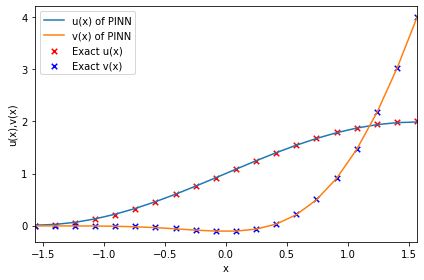

In [3]:
def ElasImag(nIter = 20000, print_period = 1000, plot_period = 1000):
    x_range = np.array([a, b])
    # Network Structure
    layers_U =[1, 40, 40,1]
    layers_V1 =[1, 40,40,1]
    layers_V2 =[1, 40, 40,1]
    layers_V3 =[1, 40, 40,1]
    layers_V4 = [1, 40, 40, 1]
    layers_V5 = [1, 40, 40, 1]


    Xx = np.linspace(x_range[0], x_range[1], 100)
    Xx = np.reshape(Xx, [-1, 1])

    f = open("loss_record.txt", "w")

    num_train_tps =100
    num_test_tps =5

    model = PhysicsInformedNN(layers_U, layers_V1,layers_V2,layers_V3,layers_V4,layers_V5, x_range, f, num_train_tps)

    it_array = []
    loss_array = []
    losses_array = []
    start_time = time.time()
    for it in range(1, nIter+1):
        loss, losses = model.train(Xx, it, it%print_period==0)
        if (it%print_period==0):
            loss_array.append(loss)
            losses_array.append(losses)
            it_array.append(it)
            dt = time.time() - start_time
            print('Time: ', dt)
            start_time = time.time()
            if (it % plot_period == 0 or it == print_period):
                print("Result Plotted...")
                plt.figure(1)
                x_test, U_test, V1_test,V2_test,V3_test,V4_test,V5_test, _,_, _, _, _, _, _,_, _, _,_,_ = model.test(num_test_tps)
                u_exact = np.sin(x_test)
                # UV_test = np.hstack((U_test, V1_test, V2_test, V3_test))
                U = np.hstack((x_test, u_exact,U_test))
                print(U)
                l2Uerror = np.linalg.norm(U_test - u_exact, 2) / np.linalg.norm(u_exact, 2)
                print('L2U error: ', l2Uerror)
                plt.figure()
                plt.plot(x_test, U_test, label='u(x) of PINN')
                plt.scatter(x_test, u_exact, s=30, c='r', marker='o', label='Exact u(x)')
                plt.legend(loc='upper left')
                plt.xlabel('x')
                plt.ylabel('u(x)')
                plt.xlim(x_range[0], x_range[1])
                plt.tight_layout()
                plt.show()
                figtopic = 'loss'
                plt.semilogy(it_array, loss_array, '-b')
                plt.xlabel("Num Iteration")
                plt.ylabel("Loss")
                plt.title(figtopic)
                plt.show()
ElasImag(nIter =20000, print_period =4000, plot_period =4000)